# Long Short-Term Memory (LSTM)

Las redes LSTM son muy eficientes para datos secuenciales, donde el orden importa. Piensa en texto (una secuencia de palabras), series temporales (precios de acciones a lo largo del tiempo o temperatura) o audio.

Tienen un "estado interno" o "memoria" que se actualiza en cada paso de la secuencia. Esto les permite recordar información de pasos anteriores para tomar decisiones en el presente. 

Ejemplos: Predecir la siguiente palabra en una oración, clasificar el sentimiento de una reseña de película, o predecir el clima de mañana basándose en los datos de la última semana.

### Dataset
Crearemos uno: una simple onda senoidal. Esto es ideal porque es un patrón periódico y predecible, lo que nos permite verificar visualmente si nuestro modelo está aprendiendo correctamente.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import LeaveOneGroupOut
from tensorflow.keras import Input
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [2]:
def create_subject_sequences(X, y, subjects, window_size=10, stride=1):
    """
    Genera secuencias tipo sliding window de largo window_size
    para cada sujeto por separado.

    Parámetros:
        X: np.ndarray de forma (N, F) con todas las muestras
        y: np.ndarray de forma (N,) con etiquetas bin. por muestra
        subjects: np.ndarray de forma (N,) con id de sujeto por muestra
        window_size: int, número de filas por secuencia
        stride: int, paso entre ventanas deslizantes

    Devuelve:
        X_seq: np.ndarray (M, window_size, F)
        y_seq: np.ndarray (M,)          -- etiqueta de la última muestra de cada ventana
        subj_seq: np.ndarray (M,)       -- id de sujeto de cada secuencia
    """
    X_seqs, y_seqs, subj_seqs = [], [], []
    for subj in np.unique(subjects):
        mask = (subjects == subj)
        X_subj = X[mask]
        y_subj = y[mask]

        # ⚠️ Normalización z-score por sujeto
        mean = np.mean(X_subj, axis=0)
        std = np.std(X_subj, axis=0)
        std[std == 0] = 1  # Evitar división por cero
        X_subj = (X_subj - mean) / std

        L = len(X_subj)
        if L < window_size:
            continue

        # ventanas con stride configurable
        for start in range(0, L - window_size + 1, stride):
            end = start + window_size
            X_seqs.append(X_subj[start:end])
            y_seqs.append(y_subj[end - 1])
            subj_seqs.append(subj)

    return np.array(X_seqs), np.array(y_seqs), np.array(subj_seqs)

def calculate_optimal_class_weight(y_train, y_test, sujeto_num):
    """
    Calcula class_weight óptimo considerando la distribución específica de cada sujeto
    """
    # Distribución del entrenamiento
    train_counts = np.bincount(y_train)
    train_ratio = train_counts[0] / train_counts[1] if len(train_counts) > 1 else 1
    
    # Distribución del test
    test_counts = np.bincount(y_test) 
    test_ratio = test_counts[0] / test_counts[1] if len(test_counts) > 1 else 1
    
    # Calcular weights base
    base_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), base_weights))
    
    # 🎯 AJUSTES ESPECÍFICOS por rango de sujetos
    if 16 <= sujeto_num <= 30:  # Sujetos problemáticos
        # Incrementar peso de clase minoritaria más agresivamente
        if test_ratio > 1.2:  # Si test está desbalanceado
            class_weight_dict[1] *= 2.0  # Doble peso a clase 1
            print(f"🔧 Sujeto {sujeto_num}: Ajuste AGRESIVO class_weight (test_ratio: {test_ratio:.2f})")
        else:
            class_weight_dict[1] *= 1.5
            print(f"🔧 Sujeto {sujeto_num}: Ajuste MODERADO class_weight (test_ratio: {test_ratio:.2f})")
    
    elif train_ratio > 2.5:  # Otros casos con desbalance
        class_weight_dict[1] *= 1.3
        print(f"🔧 Sujeto {sujeto_num}: Ajuste LEVE class_weight (train_ratio: {train_ratio:.2f})")
    
    return class_weight_dict


In [3]:
df = pd.read_csv(r'features_30_075\features.csv', index_col=0)

In [4]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 73554
Label: 2 total: 48333
Label: 3 total: 42875
Label: 4 total: 43068
Label: 5 total: 13228


In [5]:
# Filtrar los que sean 3 y 4
df = df[df['label'] != 3]
df = df[df['label'] != 4]

# Reasignar las clases
df['label'] = df['label'].apply(lambda x: 0 if x in [1, 5] else 1)

In [6]:
for i in range(0, len(df['label'].unique())):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 0 total: 86782
Label: 1 total: 48333


In [7]:
feature_cols = [col for col in df.columns if col not in ['label', 'subject']]

In [8]:
X = df[feature_cols].values
y = df['label'].values
subjects = df['subject'].values

import numpy as np
import pandas as pd

df_temp = pd.DataFrame({
    'subject': np.ravel(subjects),
    'label': np.ravel(y)
})

# Contar clases únicas por sujeto
clases_por_sujeto = df_temp.groupby('subject')['label'].nunique()

# Filtrar sujetos que tienen ambas clases (0 y 1)
sujetos_validos = clases_por_sujeto[clases_por_sujeto == 2].index.tolist()

# Obtener índices válidos
indices_validos = df_temp['subject'].isin(sujetos_validos)

# Filtrar X, y, subjects
X_filtrado = X[indices_validos]
y_filtrado = y[indices_validos]
subjects_filtrados = subjects[indices_validos]

from sklearn.preprocessing import RobustScaler

# Suponiendo que ya tienes X, y, subjects
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_filtrado)

print(X_scaled.shape)  # (num_samples, seq_len, num_features)
print(y_filtrado.shape)

(135115, 52)
(135115,)


In [9]:
X_seq, y_seq, subj_seq = create_subject_sequences(X_scaled, y_filtrado, subjects_filtrados, window_size=10, stride=5)

In [10]:
print(X_seq.shape)

(26970, 10, 52)


In [11]:
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


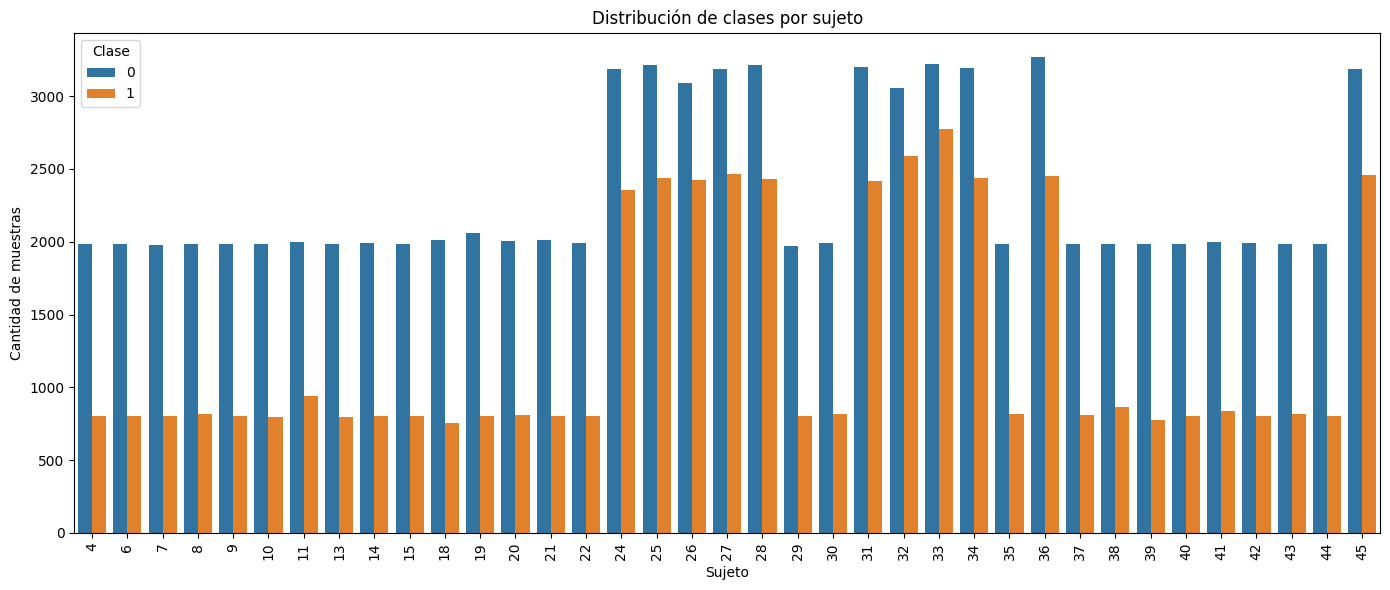

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar que son arrays 1D
subjects_flat = np.ravel(subjects_filtrados)
y_flat = np.ravel(y_filtrado)

# Crear DataFrame temporal para análisis
df_temp = pd.DataFrame({
    'subject': subjects_flat,
    'label': y_flat
})

# Contar clases por sujeto
counts = df_temp.groupby(['subject', 'label']).size().reset_index(name='count')

# Gráfico de barras
plt.figure(figsize=(14, 6))
sns.barplot(data=counts, x='subject', y='count', hue='label')
plt.title('Distribución de clases por sujeto')
plt.xlabel('Sujeto')
plt.ylabel('Cantidad de muestras')
plt.xticks(rotation=90)
plt.legend(title='Clase')
plt.tight_layout()
plt.show()


🧪 Validando grupo 1 de 37
Clases en test (sujeto 1): {0: 396, 1: 160}
Epoch 1/50
826/826 [==============================] - 7s 5ms/step - loss: 0.6787 - accuracy: 0.5490 - val_loss: 0.6125 - val_accuracy: 0.6853

Epoch 00001: val_accuracy improved from -inf to 0.68525, saving model to modelos_m\mejor_modelo_1.h5
Epoch 2/50
826/826 [==============================] - 3s 4ms/step - loss: 0.6229 - accuracy: 0.6280 - val_loss: 0.5064 - val_accuracy: 0.7626

Epoch 00002: val_accuracy improved from 0.68525 to 0.76259, saving model to modelos_m\mejor_modelo_1.h5
Epoch 3/50
826/826 [==============================] - 3s 4ms/step - loss: 0.5853 - accuracy: 0.6568 - val_loss: 0.4719 - val_accuracy: 0.7698

Epoch 00003: val_accuracy improved from 0.76259 to 0.76978, saving model to modelos_m\mejor_modelo_1.h5
Epoch 4/50
826/826 [==============================] - 3s 4ms/step - loss: 0.5770 - accuracy: 0.6663 - val_loss: 0.4615 - val_accuracy: 0.7770

Epoch 00004: val_accuracy improved from 0.76978 

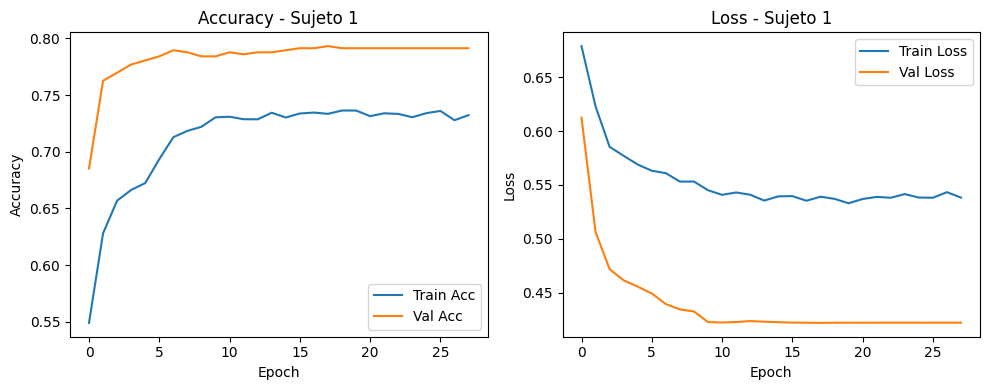

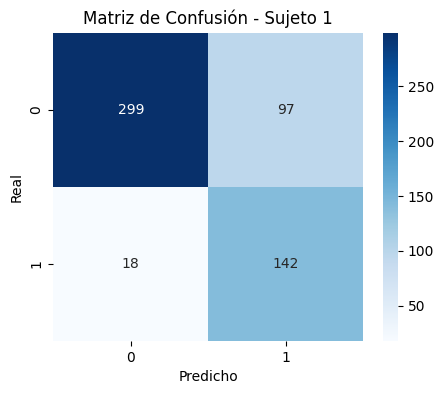

📄 Reporte de clasificación - Sujeto 1
              precision    recall  f1-score   support

           0     0.9432    0.7551    0.8387       396
           1     0.5941    0.8875    0.7118       160

    accuracy                         0.7932       556
   macro avg     0.7687    0.8213    0.7752       556
weighted avg     0.8428    0.7932    0.8022       556


🧪 Validando grupo 2 de 37
Clases en test (sujeto 2): {0: 395, 1: 160}
Epoch 1/50
826/826 [==============================] - 6s 5ms/step - loss: 0.6856 - accuracy: 0.5414 - val_loss: 0.6428 - val_accuracy: 0.6432

Epoch 00001: val_accuracy improved from -inf to 0.64324, saving model to modelos_m\mejor_modelo_2.h5
Epoch 2/50
826/826 [==============================] - 4s 4ms/step - loss: 0.6407 - accuracy: 0.6290 - val_loss: 0.5286 - val_accuracy: 0.7730

Epoch 00002: val_accuracy improved from 0.64324 to 0.77297, saving model to modelos_m\mejor_modelo_2.h5
Epoch 3/50
826/826 [==============================] - 3s 4ms/step - loss:

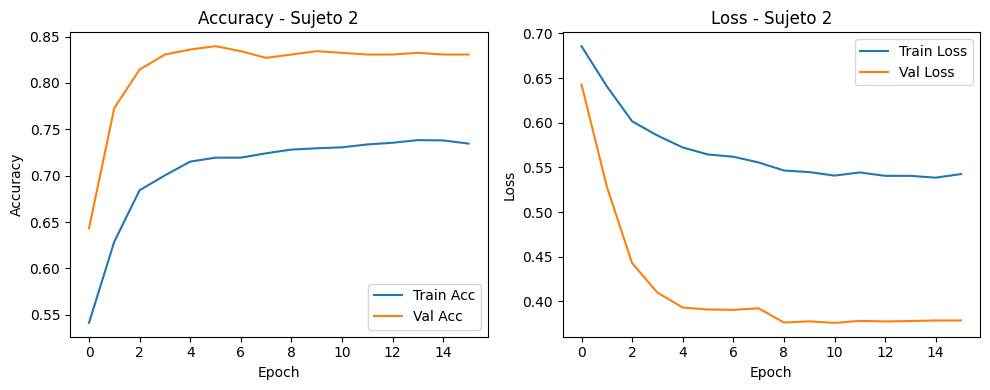

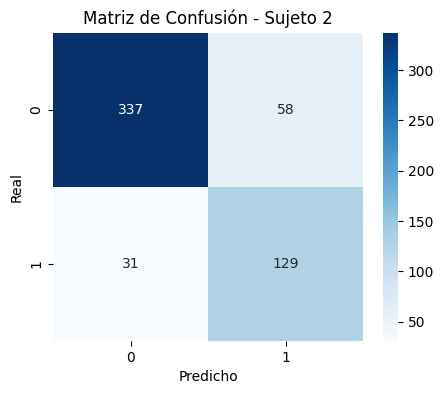

📄 Reporte de clasificación - Sujeto 2
              precision    recall  f1-score   support

           0     0.9158    0.8532    0.8834       395
           1     0.6898    0.8063    0.7435       160

    accuracy                         0.8396       555
   macro avg     0.8028    0.8297    0.8134       555
weighted avg     0.8506    0.8396    0.8430       555


🧪 Validando grupo 3 de 37
Clases en test (sujeto 3): {0: 394, 1: 161}
Epoch 1/50
826/826 [==============================] - 6s 5ms/step - loss: 0.6793 - accuracy: 0.6064 - val_loss: 0.6442 - val_accuracy: 0.6775

Epoch 00001: val_accuracy improved from -inf to 0.67748, saving model to modelos_m\mejor_modelo_3.h5
Epoch 2/50
826/826 [==============================] - 3s 4ms/step - loss: 0.6324 - accuracy: 0.6770 - val_loss: 0.5488 - val_accuracy: 0.7441

Epoch 00002: val_accuracy improved from 0.67748 to 0.74414, saving model to modelos_m\mejor_modelo_3.h5
Epoch 3/50
826/826 [==============================] - 3s 4ms/step - loss:

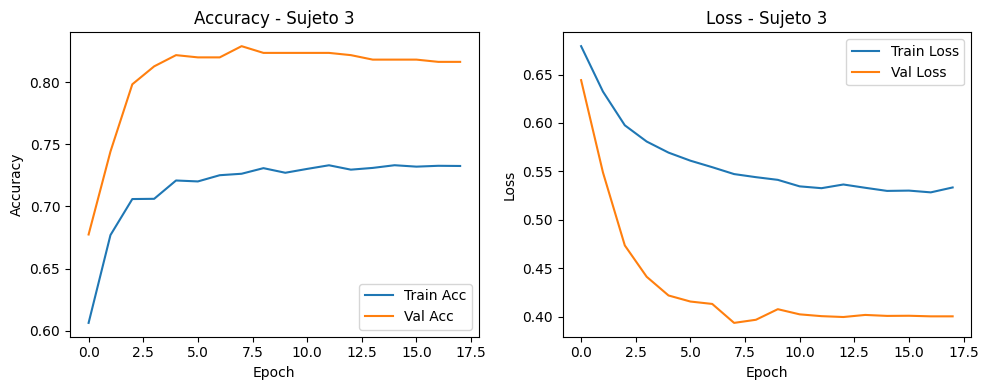

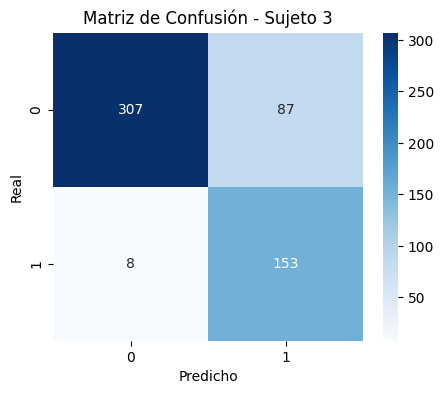

📄 Reporte de clasificación - Sujeto 3
              precision    recall  f1-score   support

           0     0.9746    0.7792    0.8660       394
           1     0.6375    0.9503    0.7631       161

    accuracy                         0.8288       555
   macro avg     0.8061    0.8647    0.8146       555
weighted avg     0.8768    0.8288    0.8362       555


🧪 Validando grupo 4 de 37
Clases en test (sujeto 4): {0: 396, 1: 164}
Epoch 1/50
826/826 [==============================] - 6s 5ms/step - loss: 0.6787 - accuracy: 0.5594 - val_loss: 0.6570 - val_accuracy: 0.5804

Epoch 00001: val_accuracy improved from -inf to 0.58036, saving model to modelos_m\mejor_modelo_4.h5
Epoch 2/50
826/826 [==============================] - 4s 4ms/step - loss: 0.6311 - accuracy: 0.6253 - val_loss: 0.6145 - val_accuracy: 0.5982

Epoch 00002: val_accuracy improved from 0.58036 to 0.59821, saving model to modelos_m\mejor_modelo_4.h5
Epoch 3/50
826/826 [==============================] - 3s 4ms/step - loss:

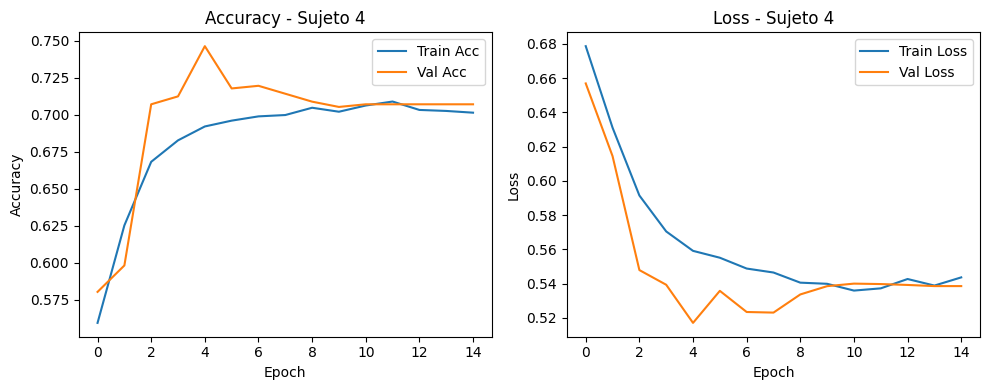

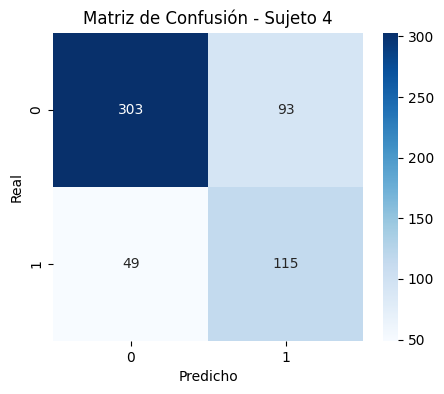

📄 Reporte de clasificación - Sujeto 4
              precision    recall  f1-score   support

           0     0.8608    0.7652    0.8102       396
           1     0.5529    0.7012    0.6183       164

    accuracy                         0.7464       560
   macro avg     0.7068    0.7332    0.7142       560
weighted avg     0.7706    0.7464    0.7540       560


🧪 Validando grupo 5 de 37
Clases en test (sujeto 5): {0: 395, 1: 160}
Epoch 1/50
826/826 [==============================] - 6s 5ms/step - loss: 0.6818 - accuracy: 0.5710 - val_loss: 0.5570 - val_accuracy: 0.8793

Epoch 00001: val_accuracy improved from -inf to 0.87928, saving model to modelos_m\mejor_modelo_5.h5
Epoch 2/50
826/826 [==============================] - 4s 4ms/step - loss: 0.6255 - accuracy: 0.6662 - val_loss: 0.3951 - val_accuracy: 0.9189

Epoch 00002: val_accuracy improved from 0.87928 to 0.91892, saving model to modelos_m\mejor_modelo_5.h5
Epoch 3/50
826/826 [==============================] - 3s 4ms/step - loss:

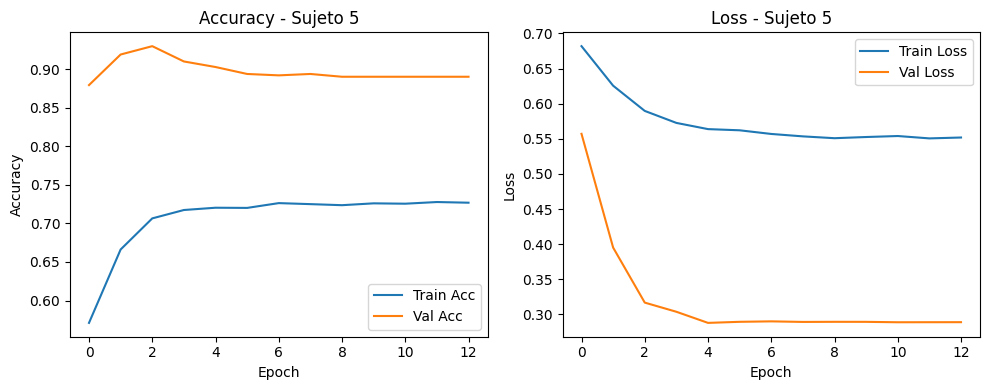

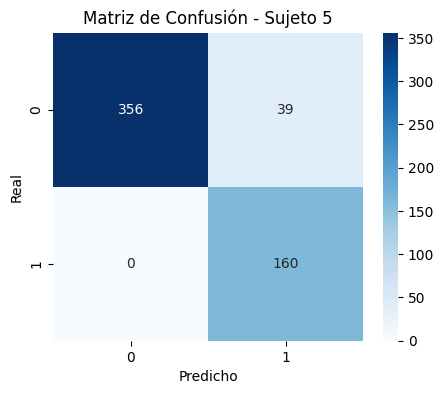

📄 Reporte de clasificación - Sujeto 5
              precision    recall  f1-score   support

           0     1.0000    0.9013    0.9481       395
           1     0.8040    1.0000    0.8914       160

    accuracy                         0.9297       555
   macro avg     0.9020    0.9506    0.9197       555
weighted avg     0.9435    0.9297    0.9317       555


🧪 Validando grupo 6 de 37
Clases en test (sujeto 6): {0: 396, 1: 159}
Epoch 1/50
826/826 [==============================] - 6s 5ms/step - loss: 0.6883 - accuracy: 0.5616 - val_loss: 0.5986 - val_accuracy: 0.7856

Epoch 00001: val_accuracy improved from -inf to 0.78559, saving model to modelos_m\mejor_modelo_6.h5
Epoch 2/50
826/826 [==============================] - 3s 4ms/step - loss: 0.6331 - accuracy: 0.6365 - val_loss: 0.4578 - val_accuracy: 0.8144

Epoch 00002: val_accuracy improved from 0.78559 to 0.81441, saving model to modelos_m\mejor_modelo_6.h5
Epoch 3/50
826/826 [==============================] - 3s 4ms/step - loss:

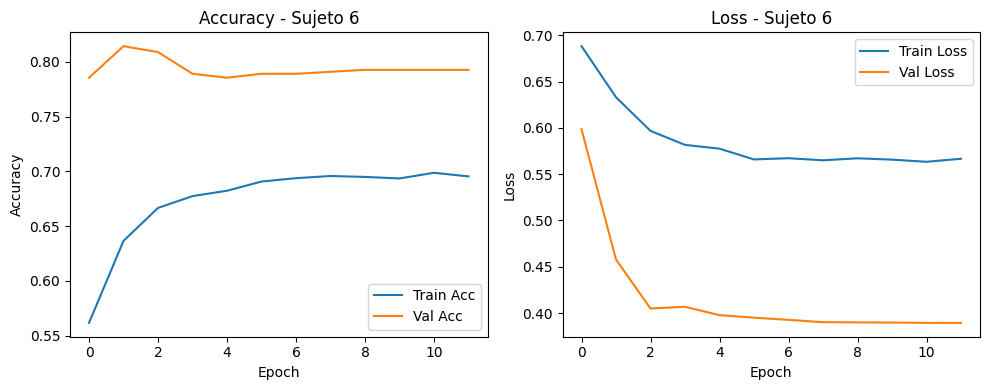

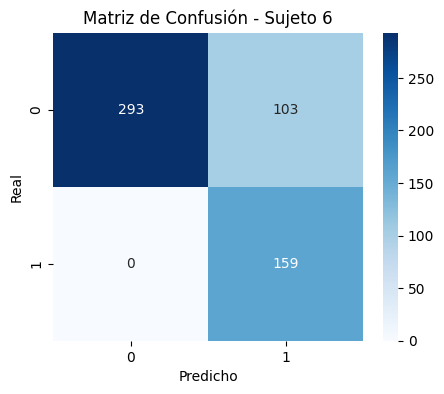

📄 Reporte de clasificación - Sujeto 6
              precision    recall  f1-score   support

           0     1.0000    0.7399    0.8505       396
           1     0.6069    1.0000    0.7553       159

    accuracy                         0.8144       555
   macro avg     0.8034    0.8699    0.8029       555
weighted avg     0.8874    0.8144    0.8232       555


🧪 Validando grupo 7 de 37
Clases en test (sujeto 7): {0: 399, 1: 188}
Epoch 1/50
825/825 [==============================] - 5s 5ms/step - loss: 0.6909 - accuracy: 0.5101 - val_loss: 0.6375 - val_accuracy: 0.7240

Epoch 00001: val_accuracy improved from -inf to 0.72402, saving model to modelos_m\mejor_modelo_7.h5
Epoch 2/50
825/825 [==============================] - 4s 4ms/step - loss: 0.6408 - accuracy: 0.6356 - val_loss: 0.5566 - val_accuracy: 0.8075

Epoch 00002: val_accuracy improved from 0.72402 to 0.80750, saving model to modelos_m\mejor_modelo_7.h5
Epoch 3/50
825/825 [==============================] - 3s 4ms/step - loss:

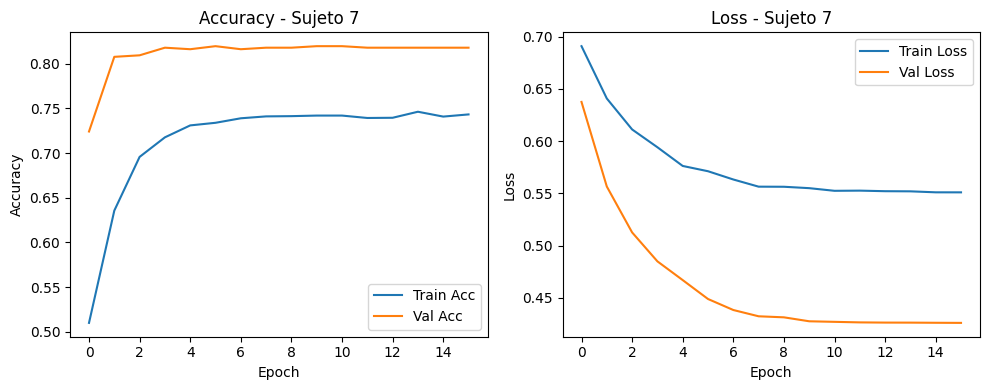

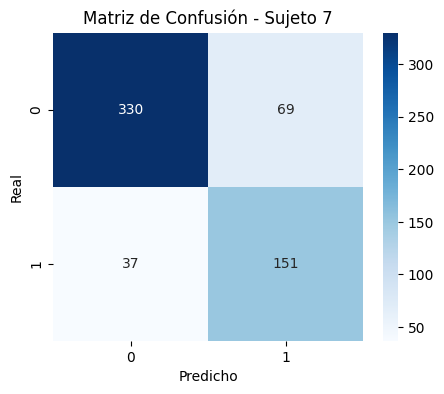

📄 Reporte de clasificación - Sujeto 7
              precision    recall  f1-score   support

           0     0.8992    0.8271    0.8616       399
           1     0.6864    0.8032    0.7402       188

    accuracy                         0.8194       587
   macro avg     0.7928    0.8151    0.8009       587
weighted avg     0.8310    0.8194    0.8227       587


🧪 Validando grupo 8 de 37
Clases en test (sujeto 8): {0: 396, 1: 159}
Epoch 1/50
826/826 [==============================] - 5s 5ms/step - loss: 0.6890 - accuracy: 0.5106 - val_loss: 0.6327 - val_accuracy: 0.7586

Epoch 00001: val_accuracy improved from -inf to 0.75856, saving model to modelos_m\mejor_modelo_8.h5
Epoch 2/50
826/826 [==============================] - 3s 4ms/step - loss: 0.6411 - accuracy: 0.6439 - val_loss: 0.5619 - val_accuracy: 0.8198

Epoch 00002: val_accuracy improved from 0.75856 to 0.81982, saving model to modelos_m\mejor_modelo_8.h5
Epoch 3/50
826/826 [==============================] - 3s 4ms/step - loss:

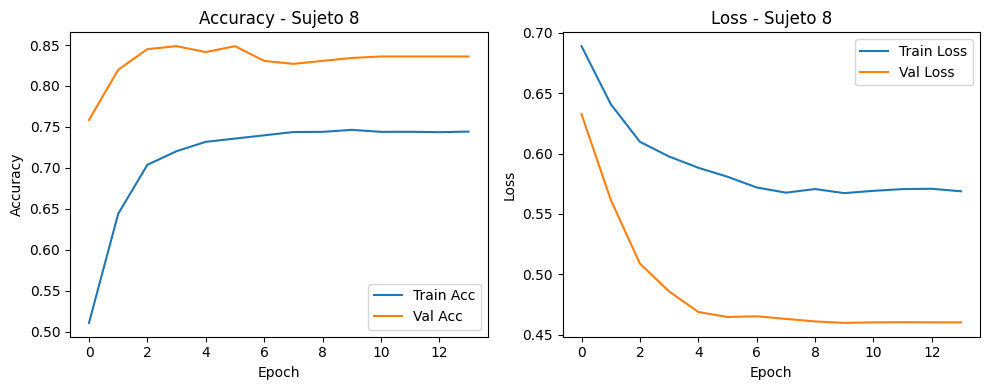

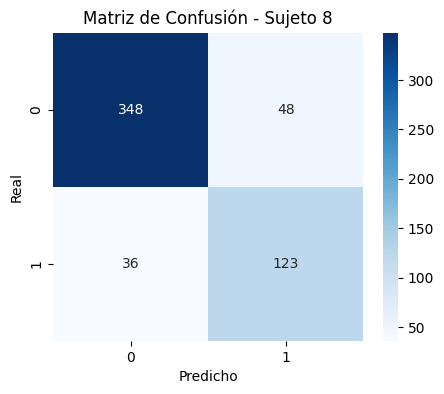

📄 Reporte de clasificación - Sujeto 8
              precision    recall  f1-score   support

           0     0.9062    0.8788    0.8923       396
           1     0.7193    0.7736    0.7455       159

    accuracy                         0.8486       555
   macro avg     0.8128    0.8262    0.8189       555
weighted avg     0.8527    0.8486    0.8502       555


🧪 Validando grupo 9 de 37
Clases en test (sujeto 9): {0: 396, 1: 161}
Epoch 1/50
826/826 [==============================] - 6s 5ms/step - loss: 0.6799 - accuracy: 0.5440 - val_loss: 0.5935 - val_accuracy: 0.7864

Epoch 00001: val_accuracy improved from -inf to 0.78636, saving model to modelos_m\mejor_modelo_9.h5
Epoch 2/50
826/826 [==============================] - 3s 4ms/step - loss: 0.6206 - accuracy: 0.6525 - val_loss: 0.4913 - val_accuracy: 0.8169

Epoch 00002: val_accuracy improved from 0.78636 to 0.81688, saving model to modelos_m\mejor_modelo_9.h5
Epoch 3/50
826/826 [==============================] - 4s 4ms/step - loss:

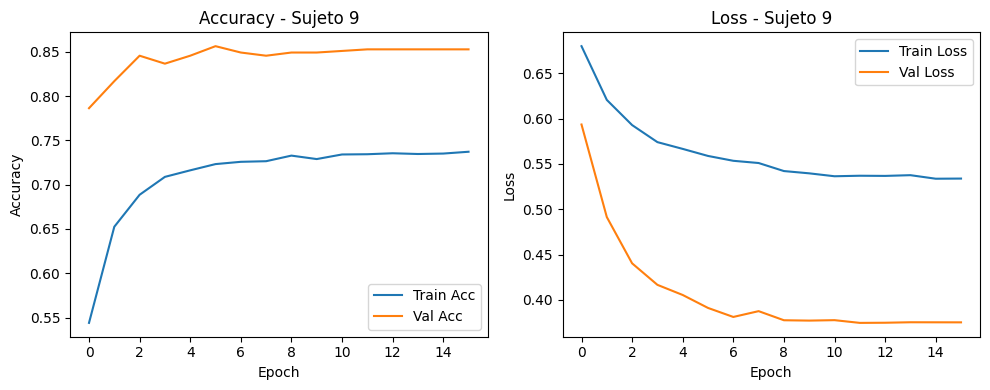

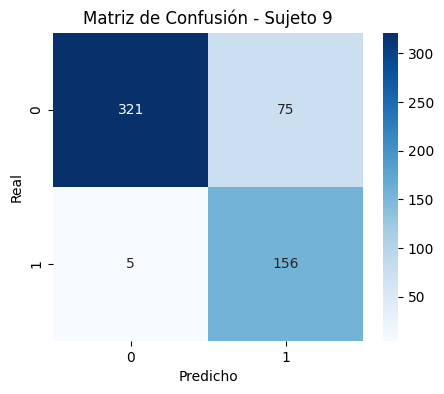

📄 Reporte de clasificación - Sujeto 9
              precision    recall  f1-score   support

           0     0.9847    0.8106    0.8892       396
           1     0.6753    0.9689    0.7959       161

    accuracy                         0.8564       557
   macro avg     0.8300    0.8898    0.8426       557
weighted avg     0.8952    0.8564    0.8622       557


🧪 Validando grupo 10 de 37
Clases en test (sujeto 10): {0: 396, 1: 160}
Epoch 1/50
826/826 [==============================] - 6s 5ms/step - loss: 0.6961 - accuracy: 0.4775 - val_loss: 0.6488 - val_accuracy: 0.7140

Epoch 00001: val_accuracy improved from -inf to 0.71403, saving model to modelos_m\mejor_modelo_10.h5
Epoch 2/50
826/826 [==============================] - 3s 4ms/step - loss: 0.6570 - accuracy: 0.6008 - val_loss: 0.5781 - val_accuracy: 0.8058

Epoch 00002: val_accuracy improved from 0.71403 to 0.80576, saving model to modelos_m\mejor_modelo_10.h5
Epoch 3/50
826/826 [==============================] - 3s 4ms/step - l

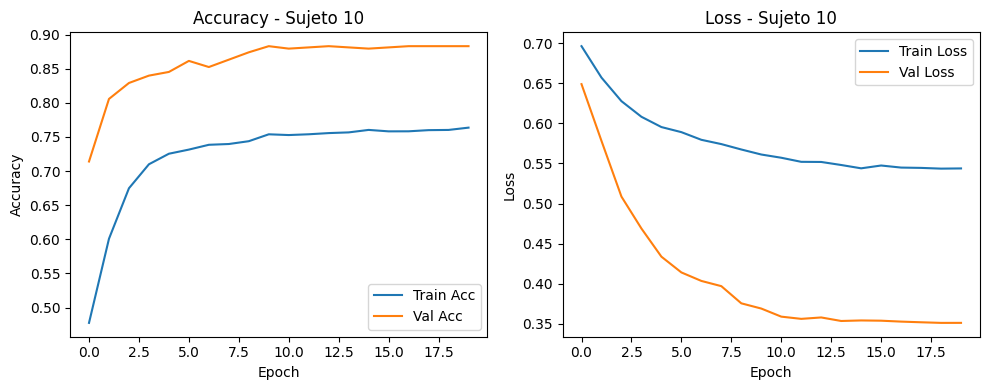

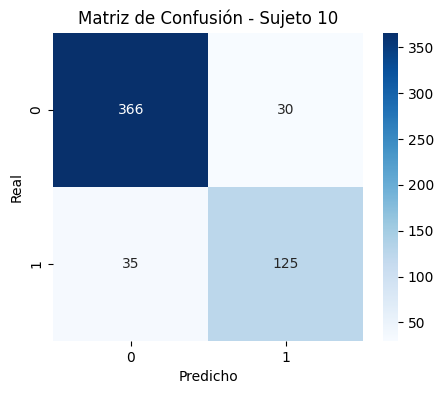

📄 Reporte de clasificación - Sujeto 10
              precision    recall  f1-score   support

           0     0.9127    0.9242    0.9184       396
           1     0.8065    0.7812    0.7937       160

    accuracy                         0.8831       556
   macro avg     0.8596    0.8527    0.8560       556
weighted avg     0.8821    0.8831    0.8825       556


🧪 Validando grupo 11 de 37
Clases en test (sujeto 11): {0: 401, 1: 151}
Epoch 1/50
826/826 [==============================] - 6s 5ms/step - loss: 0.6966 - accuracy: 0.5058 - val_loss: 0.6834 - val_accuracy: 0.5996

Epoch 00001: val_accuracy improved from -inf to 0.59964, saving model to modelos_m\mejor_modelo_11.h5
Epoch 2/50
826/826 [==============================] - 4s 4ms/step - loss: 0.6514 - accuracy: 0.5756 - val_loss: 0.6298 - val_accuracy: 0.6341

Epoch 00002: val_accuracy improved from 0.59964 to 0.63406, saving model to modelos_m\mejor_modelo_11.h5
Epoch 3/50
826/826 [==============================] - 3s 4ms/step - 

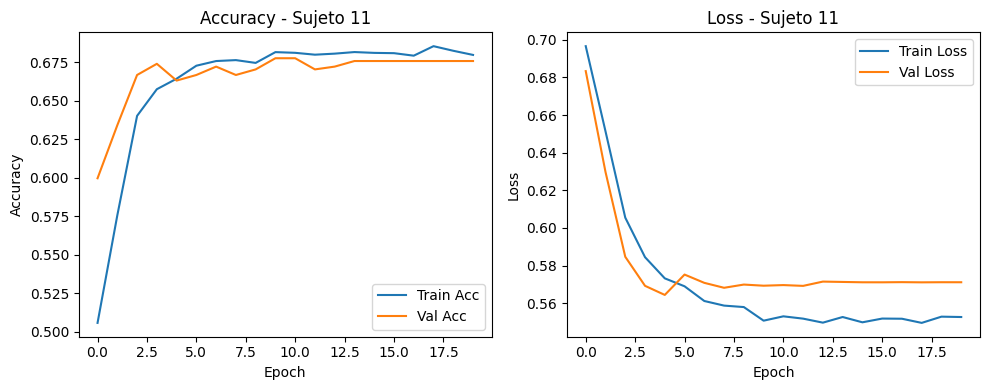

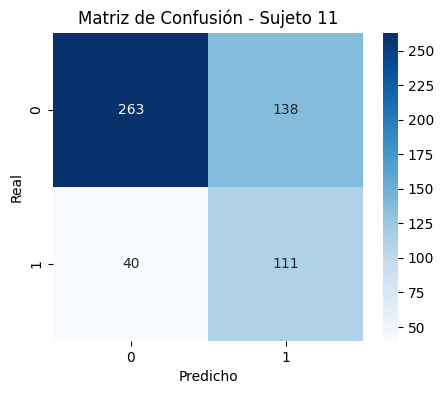

📄 Reporte de clasificación - Sujeto 11
              precision    recall  f1-score   support

           0     0.8680    0.6559    0.7472       401
           1     0.4458    0.7351    0.5550       151

    accuracy                         0.6775       552
   macro avg     0.6569    0.6955    0.6511       552
weighted avg     0.7525    0.6775    0.6946       552


🧪 Validando grupo 12 de 37
Clases en test (sujeto 12): {0: 410, 1: 161}
Epoch 1/50
825/825 [==============================] - 6s 5ms/step - loss: 0.6733 - accuracy: 0.5663 - val_loss: 0.5291 - val_accuracy: 0.7338

Epoch 00001: val_accuracy improved from -inf to 0.73380, saving model to modelos_m\mejor_modelo_12.h5
Epoch 2/50
825/825 [==============================] - 4s 4ms/step - loss: 0.6183 - accuracy: 0.6379 - val_loss: 0.4474 - val_accuracy: 0.7618

Epoch 00002: val_accuracy improved from 0.73380 to 0.76182, saving model to modelos_m\mejor_modelo_12.h5
Epoch 3/50
825/825 [==============================] - 3s 4ms/step - 

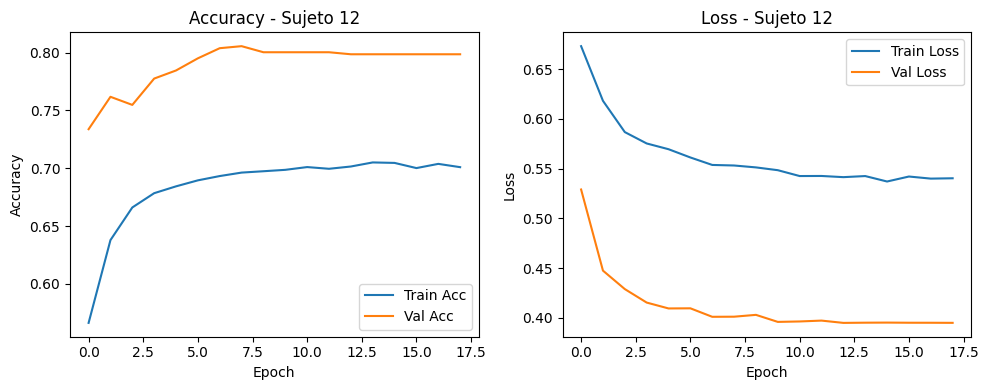

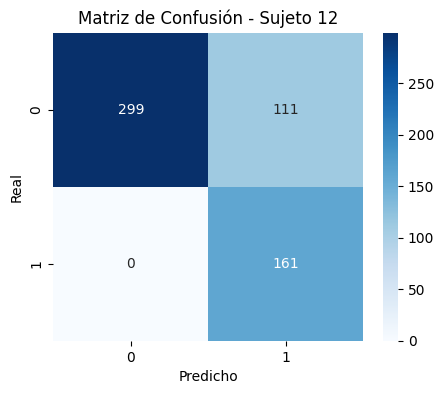

📄 Reporte de clasificación - Sujeto 12
              precision    recall  f1-score   support

           0     1.0000    0.7293    0.8434       410
           1     0.5919    1.0000    0.7436       161

    accuracy                         0.8056       571
   macro avg     0.7960    0.8646    0.7935       571
weighted avg     0.8849    0.8056    0.8153       571


🧪 Validando grupo 13 de 37
Clases en test (sujeto 13): {0: 400, 1: 162}
Epoch 1/50
826/826 [==============================] - 6s 5ms/step - loss: 0.6853 - accuracy: 0.5598 - val_loss: 0.6051 - val_accuracy: 0.7473

Epoch 00001: val_accuracy improved from -inf to 0.74733, saving model to modelos_m\mejor_modelo_13.h5
Epoch 2/50
826/826 [==============================] - 4s 4ms/step - loss: 0.6350 - accuracy: 0.6474 - val_loss: 0.5091 - val_accuracy: 0.8025

Epoch 00002: val_accuracy improved from 0.74733 to 0.80249, saving model to modelos_m\mejor_modelo_13.h5
Epoch 3/50
826/826 [==============================] - 4s 4ms/step - 

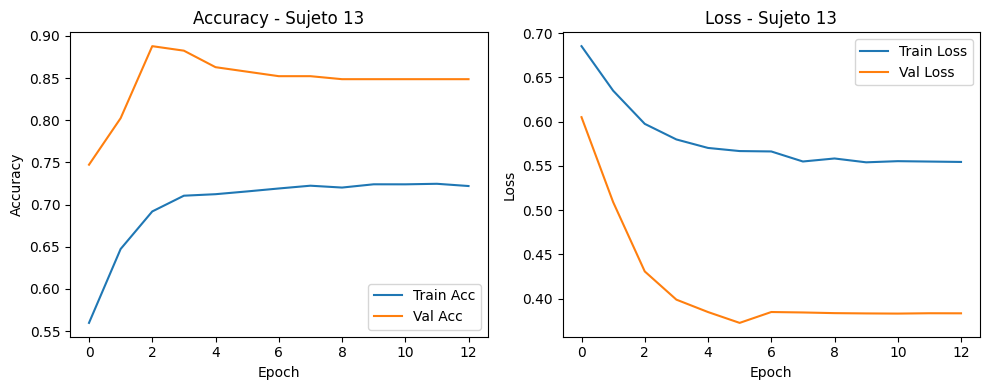

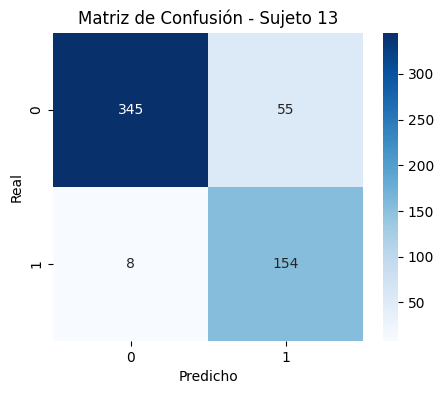

📄 Reporte de clasificación - Sujeto 13
              precision    recall  f1-score   support

           0     0.9773    0.8625    0.9163       400
           1     0.7368    0.9506    0.8302       162

    accuracy                         0.8879       562
   macro avg     0.8571    0.9066    0.8733       562
weighted avg     0.9080    0.8879    0.8915       562


🧪 Validando grupo 14 de 37
Clases en test (sujeto 14): {0: 401, 1: 161}
Epoch 1/50
826/826 [==============================] - 6s 5ms/step - loss: 0.6966 - accuracy: 0.4471 - val_loss: 0.6325 - val_accuracy: 0.8043

Epoch 00001: val_accuracy improved from -inf to 0.80427, saving model to modelos_m\mejor_modelo_14.h5
Epoch 2/50
826/826 [==============================] - 4s 4ms/step - loss: 0.6615 - accuracy: 0.5733 - val_loss: 0.5718 - val_accuracy: 0.9502

Epoch 00002: val_accuracy improved from 0.80427 to 0.95018, saving model to modelos_m\mejor_modelo_14.h5
Epoch 3/50
826/826 [==============================] - 3s 4ms/step - 

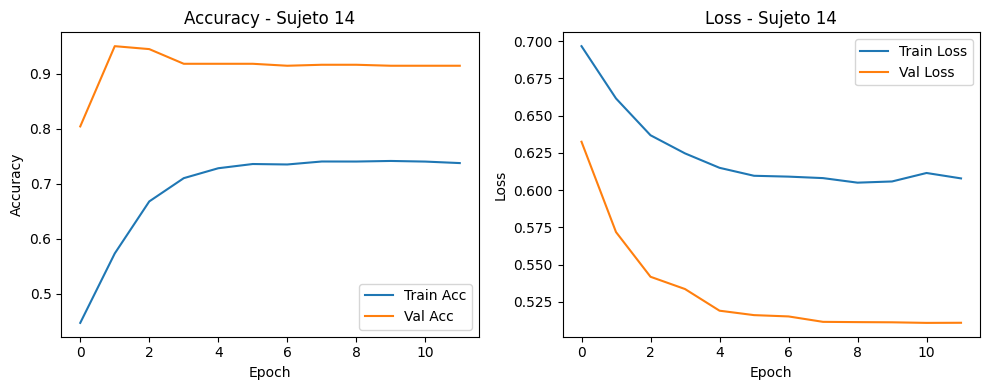

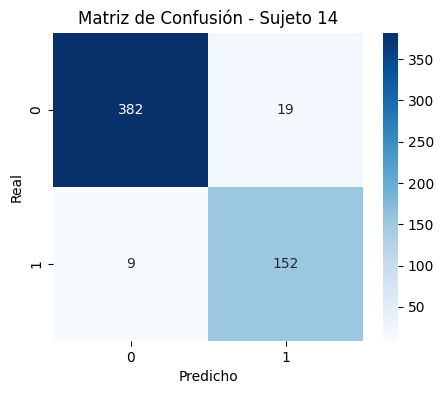

📄 Reporte de clasificación - Sujeto 14
              precision    recall  f1-score   support

           0     0.9770    0.9526    0.9646       401
           1     0.8889    0.9441    0.9157       161

    accuracy                         0.9502       562
   macro avg     0.9329    0.9484    0.9402       562
weighted avg     0.9517    0.9502    0.9506       562


🧪 Validando grupo 15 de 37
Clases en test (sujeto 15): {0: 397, 1: 160}
Epoch 1/50
826/826 [==============================] - 6s 5ms/step - loss: 0.6789 - accuracy: 0.5529 - val_loss: 0.5631 - val_accuracy: 0.8420

Epoch 00001: val_accuracy improved from -inf to 0.84201, saving model to modelos_m\mejor_modelo_15.h5
Epoch 2/50
826/826 [==============================] - 4s 4ms/step - loss: 0.6393 - accuracy: 0.6429 - val_loss: 0.4680 - val_accuracy: 0.8546

Epoch 00002: val_accuracy improved from 0.84201 to 0.85458, saving model to modelos_m\mejor_modelo_15.h5
Epoch 3/50
826/826 [==============================] - 3s 4ms/step - 

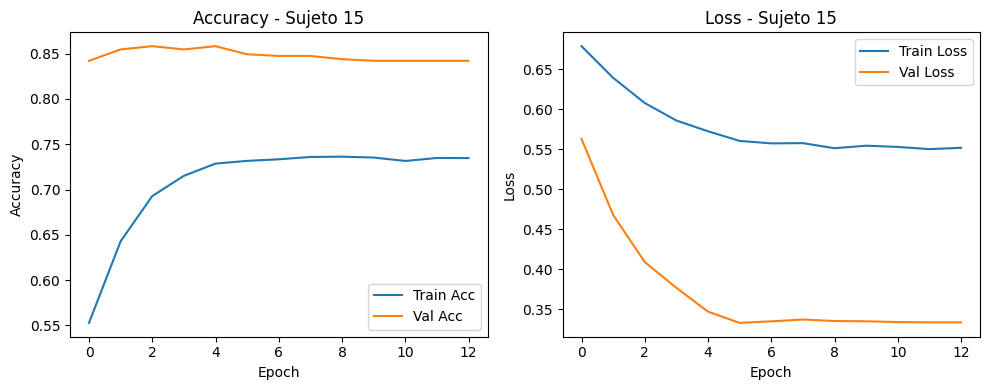

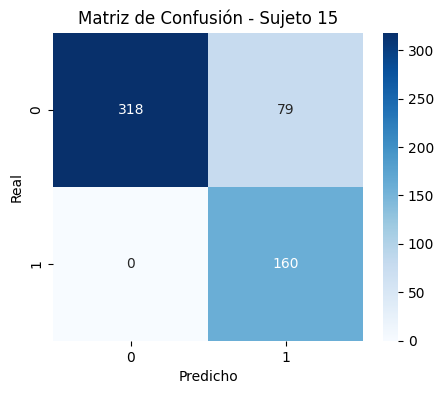

📄 Reporte de clasificación - Sujeto 15
              precision    recall  f1-score   support

           0     1.0000    0.8010    0.8895       397
           1     0.6695    1.0000    0.8020       160

    accuracy                         0.8582       557
   macro avg     0.8347    0.9005    0.8458       557
weighted avg     0.9051    0.8582    0.8644       557


🧪 Validando grupo 16 de 37
🔧 Sujeto 16: Ajuste AGRESIVO class_weight (test_ratio: 1.35)
Clases en test (sujeto 16): {0: 636, 1: 471}
Epoch 1/50
405/405 [==============================] - 4s 6ms/step - loss: 0.9702 - accuracy: 0.3841 - val_loss: 0.6953 - val_accuracy: 0.4724

Epoch 00001: val_accuracy improved from -inf to 0.47245, saving model to modelos_m\mejor_modelo_16.h5
Epoch 2/50
405/405 [==============================] - 2s 4ms/step - loss: 0.9134 - accuracy: 0.3865 - val_loss: 0.7436 - val_accuracy: 0.5583

Epoch 00002: val_accuracy improved from 0.47245 to 0.55827, saving model to modelos_m\mejor_modelo_16.h5
Epoch 3

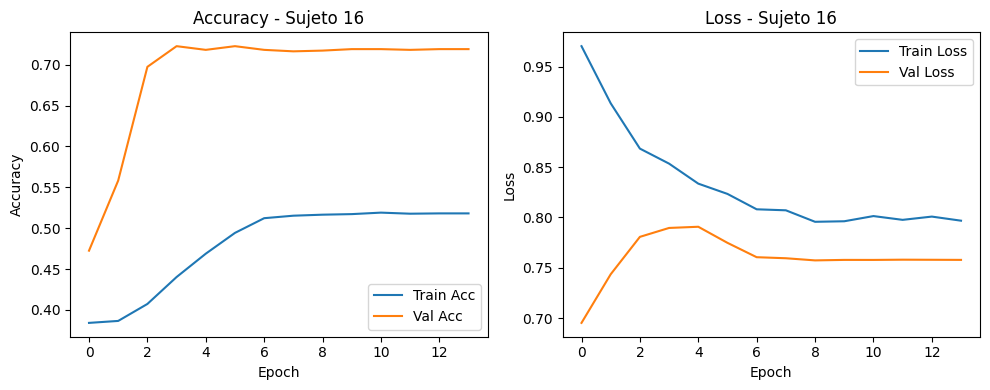

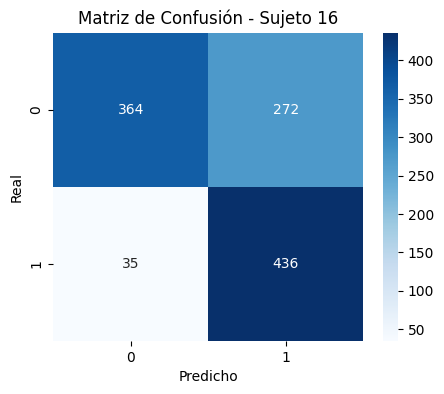

📄 Reporte de clasificación - Sujeto 16
              precision    recall  f1-score   support

           0     0.9123    0.5723    0.7034       636
           1     0.6158    0.9257    0.7396       471

    accuracy                         0.7227      1107
   macro avg     0.7640    0.7490    0.7215      1107
weighted avg     0.7861    0.7227    0.7188      1107


🧪 Validando grupo 17 de 37
🔧 Sujeto 17: Ajuste AGRESIVO class_weight (test_ratio: 1.32)
Clases en test (sujeto 17): {0: 641, 1: 487}
Epoch 1/50
404/404 [==============================] - 4s 5ms/step - loss: 1.0228 - accuracy: 0.4943 - val_loss: 0.6679 - val_accuracy: 0.6853

Epoch 00001: val_accuracy improved from -inf to 0.68528, saving model to modelos_m\mejor_modelo_17.h5
Epoch 2/50
404/404 [==============================] - 2s 4ms/step - loss: 0.9238 - accuracy: 0.5097 - val_loss: 0.6587 - val_accuracy: 0.7296

Epoch 00002: val_accuracy improved from 0.68528 to 0.72961, saving model to modelos_m\mejor_modelo_17.h5
Epoch 3

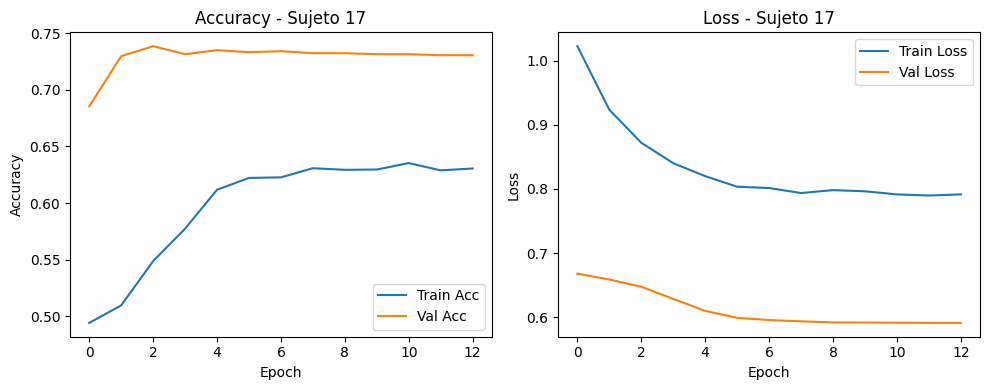

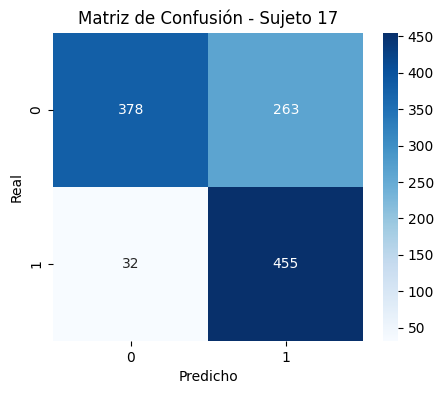

📄 Reporte de clasificación - Sujeto 17
              precision    recall  f1-score   support

           0     0.9220    0.5897    0.7193       641
           1     0.6337    0.9343    0.7552       487

    accuracy                         0.7385      1128
   macro avg     0.7778    0.7620    0.7373      1128
weighted avg     0.7975    0.7385    0.7348      1128


🧪 Validando grupo 18 de 37
🔧 Sujeto 18: Ajuste AGRESIVO class_weight (test_ratio: 1.27)
Clases en test (sujeto 18): {0: 617, 1: 485}
Epoch 1/50
405/405 [==============================] - 4s 5ms/step - loss: 1.0715 - accuracy: 0.5460 - val_loss: 0.6922 - val_accuracy: 0.5245

Epoch 00001: val_accuracy improved from -inf to 0.52450, saving model to modelos_m\mejor_modelo_18.h5
Epoch 2/50
405/405 [==============================] - 2s 4ms/step - loss: 1.0191 - accuracy: 0.5043 - val_loss: 0.6921 - val_accuracy: 0.5091

Epoch 00002: val_accuracy did not improve from 0.52450
Epoch 3/50
405/405 [==============================] - 2s 

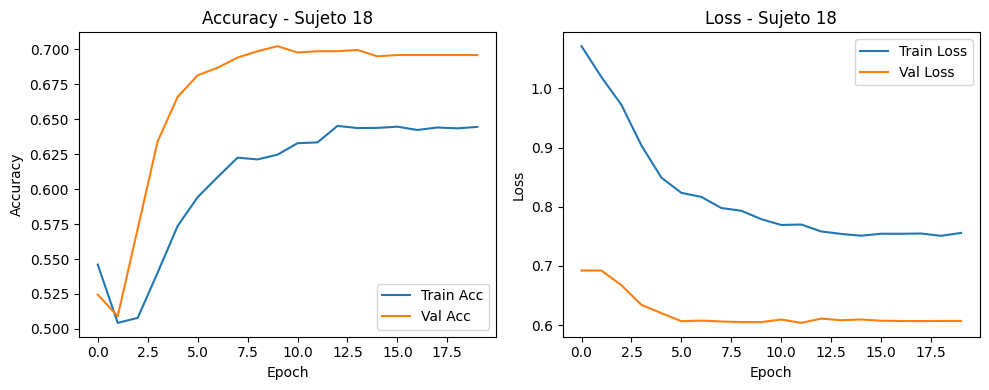

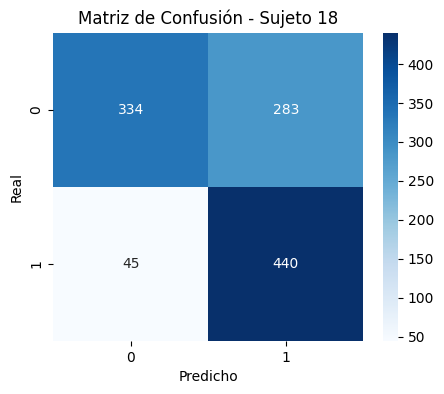

📄 Reporte de clasificación - Sujeto 18
              precision    recall  f1-score   support

           0     0.8813    0.5413    0.6707       617
           1     0.6086    0.9072    0.7285       485

    accuracy                         0.7024      1102
   macro avg     0.7449    0.7243    0.6996      1102
weighted avg     0.7613    0.7024    0.6961      1102


🧪 Validando grupo 19 de 37
🔧 Sujeto 19: Ajuste AGRESIVO class_weight (test_ratio: 1.29)
Clases en test (sujeto 19): {0: 635, 1: 493}
Epoch 1/50
404/404 [==============================] - 4s 6ms/step - loss: 0.9857 - accuracy: 0.4773 - val_loss: 0.6278 - val_accuracy: 0.7004

Epoch 00001: val_accuracy improved from -inf to 0.70035, saving model to modelos_m\mejor_modelo_19.h5
Epoch 2/50
404/404 [==============================] - 2s 4ms/step - loss: 0.9004 - accuracy: 0.5060 - val_loss: 0.6422 - val_accuracy: 0.7402

Epoch 00002: val_accuracy improved from 0.70035 to 0.74025, saving model to modelos_m\mejor_modelo_19.h5
Epoch 3

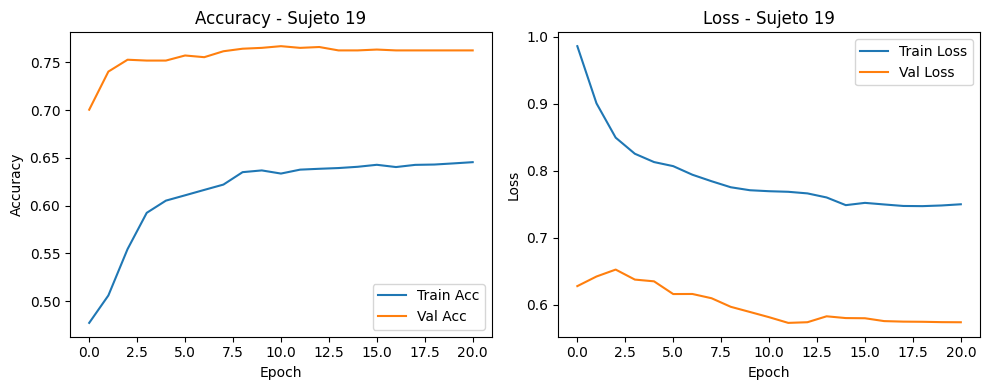

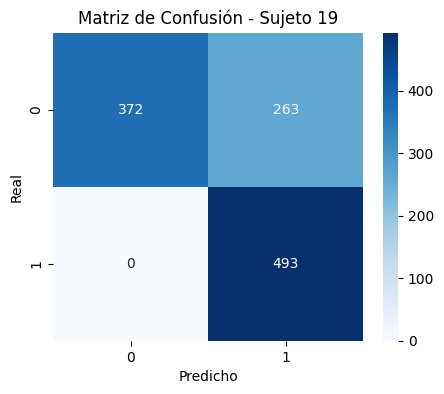

📄 Reporte de clasificación - Sujeto 19
              precision    recall  f1-score   support

           0     1.0000    0.5858    0.7388       635
           1     0.6521    1.0000    0.7894       493

    accuracy                         0.7668      1128
   macro avg     0.8261    0.7929    0.7641      1128
weighted avg     0.8480    0.7668    0.7609      1128


🧪 Validando grupo 20 de 37
🔧 Sujeto 20: Ajuste AGRESIVO class_weight (test_ratio: 1.32)
Clases en test (sujeto 20): {0: 642, 1: 486}
Epoch 1/50
404/404 [==============================] - 4s 5ms/step - loss: 1.0219 - accuracy: 0.4703 - val_loss: 0.7017 - val_accuracy: 0.4761

Epoch 00001: val_accuracy improved from -inf to 0.47606, saving model to modelos_m\mejor_modelo_20.h5
Epoch 2/50
404/404 [==============================] - 2s 5ms/step - loss: 0.9503 - accuracy: 0.4702 - val_loss: 0.7062 - val_accuracy: 0.5346

Epoch 00002: val_accuracy improved from 0.47606 to 0.53457, saving model to modelos_m\mejor_modelo_20.h5
Epoch 3

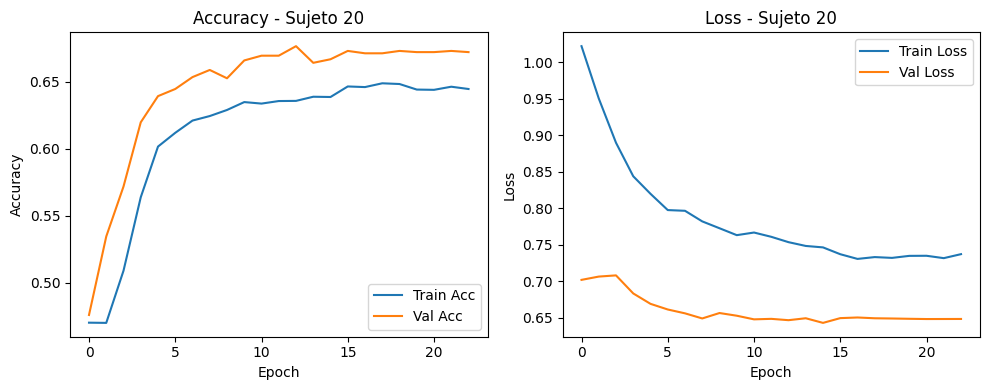

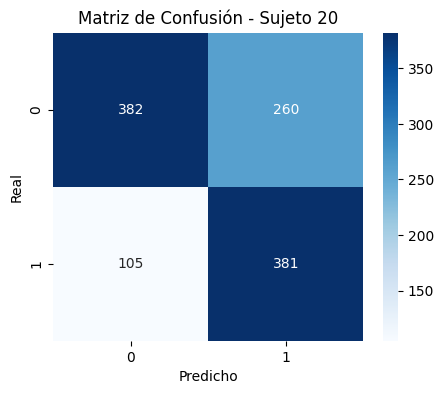

📄 Reporte de clasificación - Sujeto 20
              precision    recall  f1-score   support

           0     0.7844    0.5950    0.6767       642
           1     0.5944    0.7840    0.6761       486

    accuracy                         0.6764      1128
   macro avg     0.6894    0.6895    0.6764      1128
weighted avg     0.7025    0.6764    0.6765      1128


🧪 Validando grupo 21 de 37
🔧 Sujeto 21: Ajuste AGRESIVO class_weight (test_ratio: 2.44)
Clases en test (sujeto 21): {0: 393, 1: 161}
Epoch 1/50
413/413 [==============================] - 4s 5ms/step - loss: 0.9932 - accuracy: 0.4113 - val_loss: 0.7429 - val_accuracy: 0.3213

Epoch 00001: val_accuracy improved from -inf to 0.32130, saving model to modelos_m\mejor_modelo_21.h5
Epoch 2/50
413/413 [==============================] - 2s 4ms/step - loss: 0.9235 - accuracy: 0.4196 - val_loss: 0.7572 - val_accuracy: 0.4783

Epoch 00002: val_accuracy improved from 0.32130 to 0.47834, saving model to modelos_m\mejor_modelo_21.h5
Epoch 3

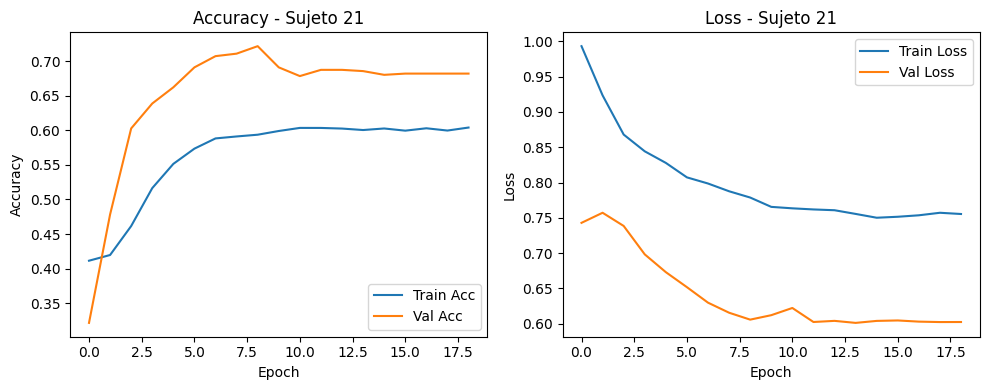

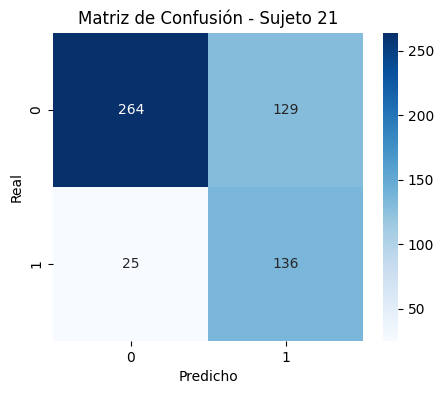

📄 Reporte de clasificación - Sujeto 21
              precision    recall  f1-score   support

           0     0.9135    0.6718    0.7742       393
           1     0.5132    0.8447    0.6385       161

    accuracy                         0.7220       554
   macro avg     0.7134    0.7582    0.7063       554
weighted avg     0.7972    0.7220    0.7348       554


🧪 Validando grupo 22 de 37
🔧 Sujeto 22: Ajuste AGRESIVO class_weight (test_ratio: 2.43)
Clases en test (sujeto 22): {0: 396, 1: 163}
Epoch 1/50
413/413 [==============================] - 4s 5ms/step - loss: 0.9980 - accuracy: 0.4174 - val_loss: 0.7105 - val_accuracy: 0.3131

Epoch 00001: val_accuracy improved from -inf to 0.31306, saving model to modelos_m\mejor_modelo_22.h5
Epoch 2/50
413/413 [==============================] - 2s 4ms/step - loss: 0.9318 - accuracy: 0.4168 - val_loss: 0.6773 - val_accuracy: 0.4043

Epoch 00002: val_accuracy improved from 0.31306 to 0.40429, saving model to modelos_m\mejor_modelo_22.h5
Epoch 3

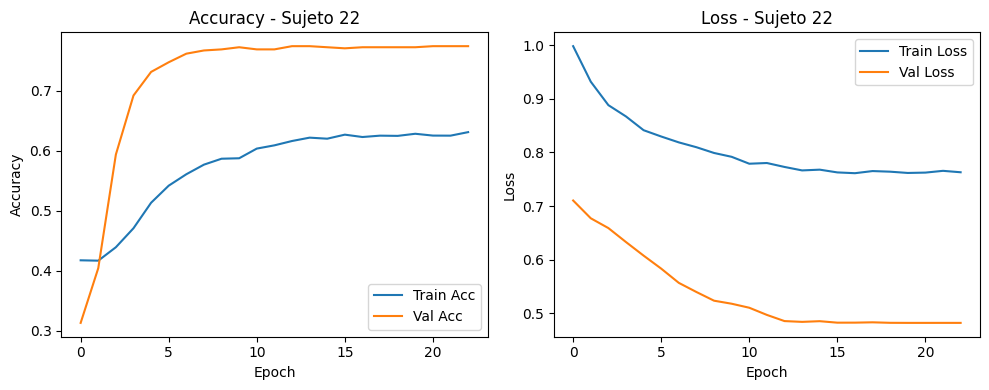

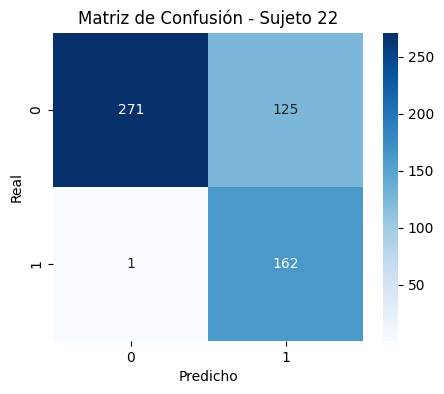

📄 Reporte de clasificación - Sujeto 22
              precision    recall  f1-score   support

           0     0.9963    0.6843    0.8114       396
           1     0.5645    0.9939    0.7200       163

    accuracy                         0.7746       559
   macro avg     0.7804    0.8391    0.7657       559
weighted avg     0.8704    0.7746    0.7847       559


🧪 Validando grupo 23 de 37
🔧 Sujeto 23: Ajuste AGRESIVO class_weight (test_ratio: 1.32)
Clases en test (sujeto 23): {0: 639, 1: 483}
Epoch 1/50
404/404 [==============================] - 4s 5ms/step - loss: 1.0000 - accuracy: 0.4371 - val_loss: 0.6795 - val_accuracy: 0.5677

Epoch 00001: val_accuracy improved from -inf to 0.56774, saving model to modelos_m\mejor_modelo_23.h5
Epoch 2/50
404/404 [==============================] - 2s 4ms/step - loss: 0.9198 - accuracy: 0.4350 - val_loss: 0.7275 - val_accuracy: 0.6070

Epoch 00002: val_accuracy improved from 0.56774 to 0.60695, saving model to modelos_m\mejor_modelo_23.h5
Epoch 3

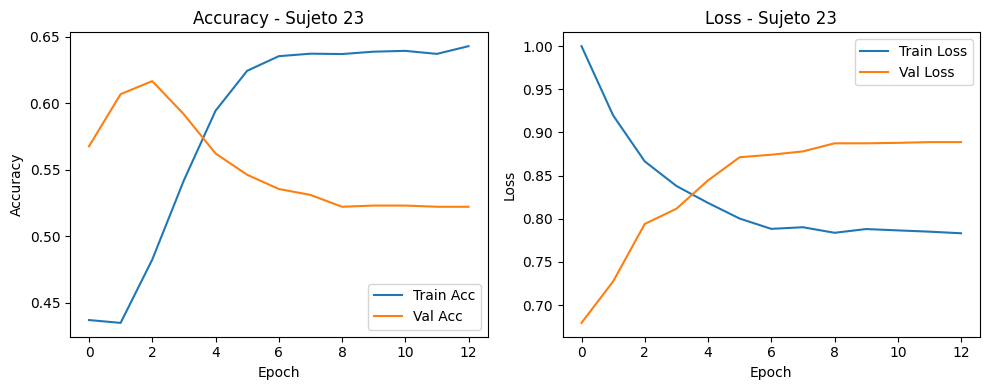

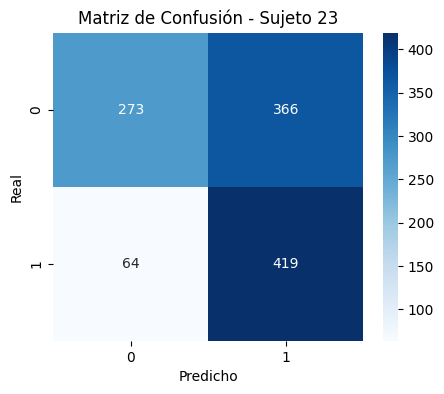

📄 Reporte de clasificación - Sujeto 23
              precision    recall  f1-score   support

           0     0.8101    0.4272    0.5594       639
           1     0.5338    0.8675    0.6609       483

    accuracy                         0.6168      1122
   macro avg     0.6719    0.6474    0.6102      1122
weighted avg     0.6911    0.6168    0.6031      1122


🧪 Validando grupo 24 de 37
🔧 Sujeto 24: Ajuste MODERADO class_weight (test_ratio: 1.18)
Clases en test (sujeto 24): {0: 611, 1: 516}
Epoch 1/50
404/404 [==============================] - 4s 5ms/step - loss: 0.8546 - accuracy: 0.5423 - val_loss: 0.6990 - val_accuracy: 0.5013

Epoch 00001: val_accuracy improved from -inf to 0.50133, saving model to modelos_m\mejor_modelo_24.h5
Epoch 2/50
404/404 [==============================] - 2s 4ms/step - loss: 0.7948 - accuracy: 0.5660 - val_loss: 0.7528 - val_accuracy: 0.4809

Epoch 00002: val_accuracy did not improve from 0.50133
Epoch 3/50
404/404 [==============================] - 2s 

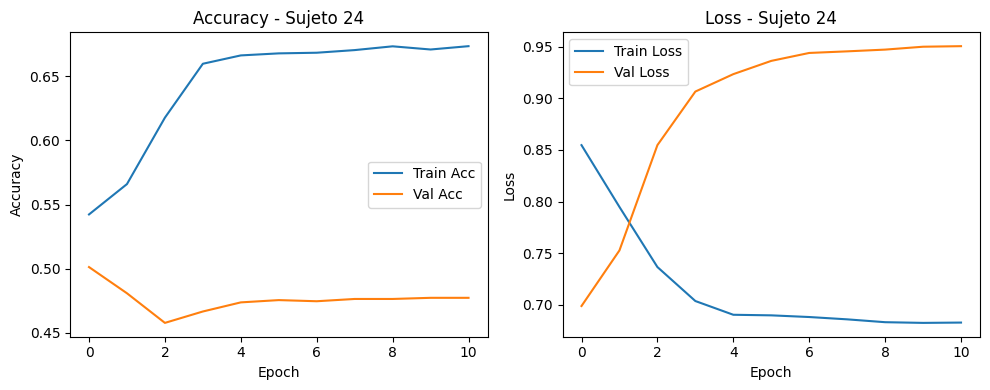

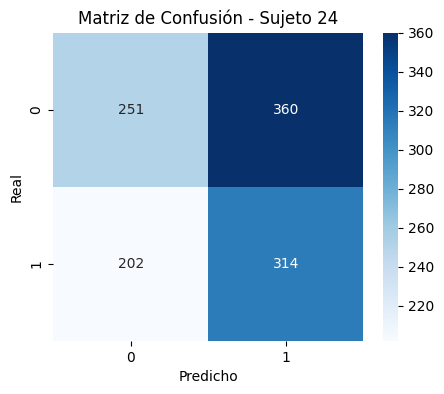

📄 Reporte de clasificación - Sujeto 24
              precision    recall  f1-score   support

           0     0.5541    0.4108    0.4718       611
           1     0.4659    0.6085    0.5277       516

    accuracy                         0.5013      1127
   macro avg     0.5100    0.5097    0.4998      1127
weighted avg     0.5137    0.5013    0.4974      1127


🧪 Validando grupo 25 de 37
🔧 Sujeto 25: Ajuste MODERADO class_weight (test_ratio: 1.16)
Clases en test (sujeto 25): {0: 642, 1: 555}
Epoch 1/50
403/403 [==============================] - 4s 6ms/step - loss: 0.8375 - accuracy: 0.4431 - val_loss: 0.6966 - val_accuracy: 0.5940

Epoch 00001: val_accuracy improved from -inf to 0.59398, saving model to modelos_m\mejor_modelo_25.h5
Epoch 2/50
403/403 [==============================] - 2s 4ms/step - loss: 0.7770 - accuracy: 0.5038 - val_loss: 0.7052 - val_accuracy: 0.6224

Epoch 00002: val_accuracy improved from 0.59398 to 0.62239, saving model to modelos_m\mejor_modelo_25.h5
Epoch 3

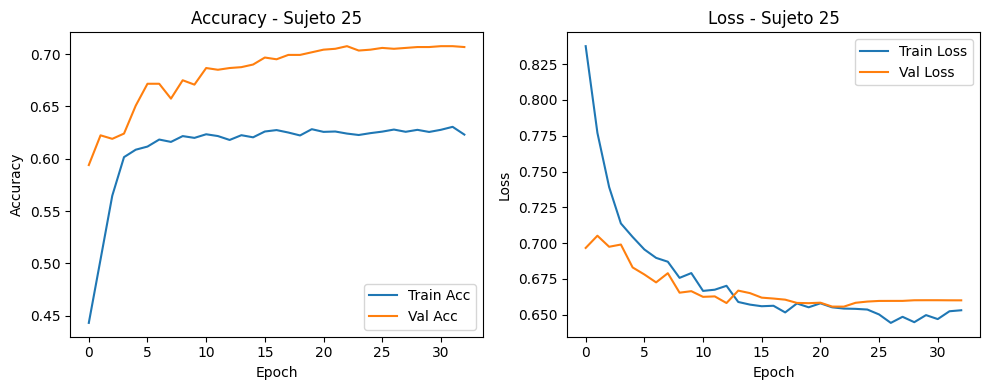

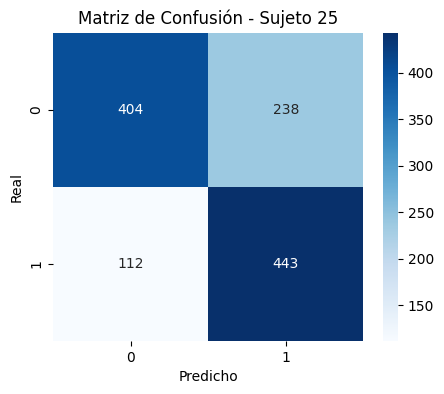

📄 Reporte de clasificación - Sujeto 25
              precision    recall  f1-score   support

           0     0.7829    0.6293    0.6978       642
           1     0.6505    0.7982    0.7168       555

    accuracy                         0.7076      1197
   macro avg     0.7167    0.7137    0.7073      1197
weighted avg     0.7215    0.7076    0.7066      1197


🧪 Validando grupo 26 de 37
🔧 Sujeto 26: Ajuste AGRESIVO class_weight (test_ratio: 1.31)
Clases en test (sujeto 26): {0: 637, 1: 488}
Epoch 1/50
404/404 [==============================] - 4s 6ms/step - loss: 0.9927 - accuracy: 0.4114 - val_loss: 0.8070 - val_accuracy: 0.4418

Epoch 00001: val_accuracy improved from -inf to 0.44178, saving model to modelos_m\mejor_modelo_26.h5
Epoch 2/50
404/404 [==============================] - 2s 4ms/step - loss: 0.9181 - accuracy: 0.4140 - val_loss: 0.8820 - val_accuracy: 0.4898

Epoch 00002: val_accuracy improved from 0.44178 to 0.48978, saving model to modelos_m\mejor_modelo_26.h5
Epoch 3

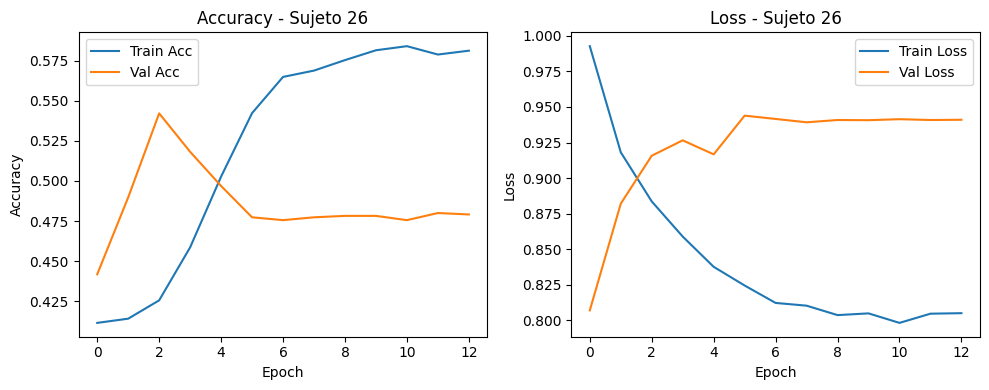

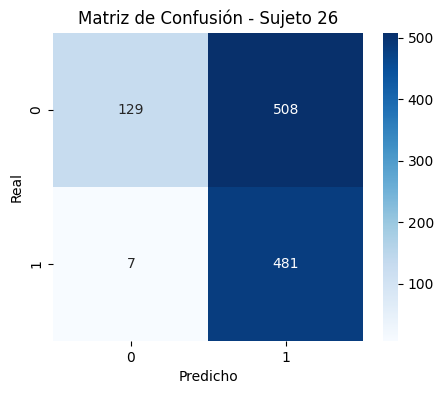

📄 Reporte de clasificación - Sujeto 26
              precision    recall  f1-score   support

           0     0.9485    0.2025    0.3338       637
           1     0.4863    0.9857    0.6513       488

    accuracy                         0.5422      1125
   macro avg     0.7174    0.5941    0.4925      1125
weighted avg     0.7480    0.5422    0.4715      1125


🧪 Validando grupo 27 de 37
🔧 Sujeto 27: Ajuste AGRESIVO class_weight (test_ratio: 2.42)
Clases en test (sujeto 27): {0: 395, 1: 163}
Epoch 1/50
413/413 [==============================] - 4s 5ms/step - loss: 1.0527 - accuracy: 0.4735 - val_loss: 0.7137 - val_accuracy: 0.3333

Epoch 00001: val_accuracy improved from -inf to 0.33333, saving model to modelos_m\mejor_modelo_27.h5
Epoch 2/50
413/413 [==============================] - 2s 4ms/step - loss: 0.9605 - accuracy: 0.4565 - val_loss: 0.7552 - val_accuracy: 0.3746

Epoch 00002: val_accuracy improved from 0.33333 to 0.37455, saving model to modelos_m\mejor_modelo_27.h5
Epoch 3

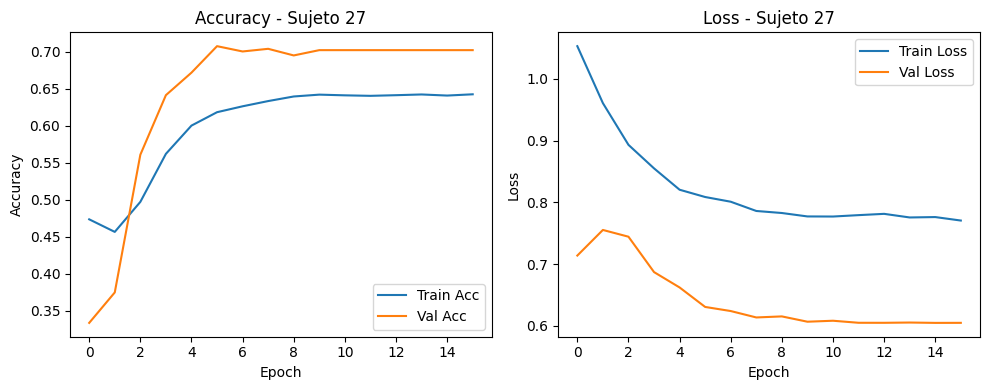

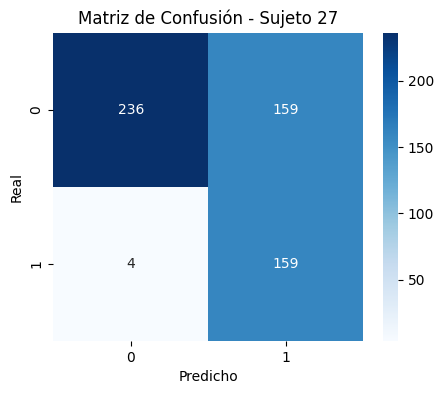

📄 Reporte de clasificación - Sujeto 27
              precision    recall  f1-score   support

           0     0.9833    0.5975    0.7433       395
           1     0.5000    0.9755    0.6611       163

    accuracy                         0.7079       558
   macro avg     0.7417    0.7865    0.7022       558
weighted avg     0.8421    0.7079    0.7193       558


🧪 Validando grupo 28 de 37
🔧 Sujeto 28: Ajuste AGRESIVO class_weight (test_ratio: 1.33)
Clases en test (sujeto 28): {0: 654, 1: 490}
Epoch 1/50
404/404 [==============================] - 4s 5ms/step - loss: 1.0001 - accuracy: 0.4994 - val_loss: 0.7070 - val_accuracy: 0.5603

Epoch 00001: val_accuracy improved from -inf to 0.56031, saving model to modelos_m\mejor_modelo_28.h5
Epoch 2/50
404/404 [==============================] - 2s 4ms/step - loss: 0.9096 - accuracy: 0.5209 - val_loss: 0.7732 - val_accuracy: 0.5673

Epoch 00002: val_accuracy improved from 0.56031 to 0.56731, saving model to modelos_m\mejor_modelo_28.h5
Epoch 3

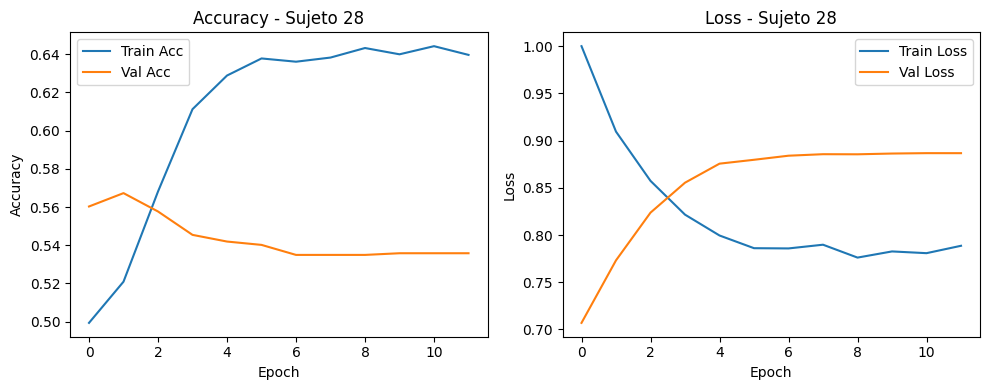

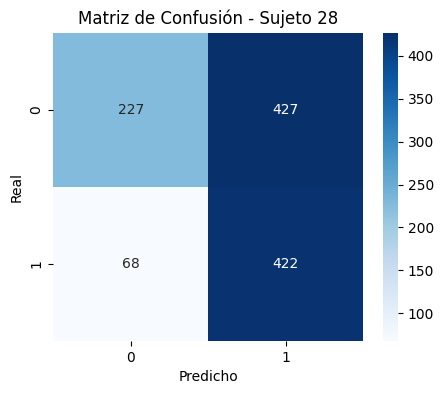

📄 Reporte de clasificación - Sujeto 28
              precision    recall  f1-score   support

           0     0.7695    0.3471    0.4784       654
           1     0.4971    0.8612    0.6303       490

    accuracy                         0.5673      1144
   macro avg     0.6333    0.6042    0.5544      1144
weighted avg     0.6528    0.5673    0.5435      1144


🧪 Validando grupo 29 de 37
🔧 Sujeto 29: Ajuste AGRESIVO class_weight (test_ratio: 2.44)
Clases en test (sujeto 29): {0: 396, 1: 162}
Epoch 1/50
413/413 [==============================] - 4s 5ms/step - loss: 0.9882 - accuracy: 0.4007 - val_loss: 0.7260 - val_accuracy: 0.3280

Epoch 00001: val_accuracy improved from -inf to 0.32796, saving model to modelos_m\mejor_modelo_29.h5
Epoch 2/50
413/413 [==============================] - 2s 4ms/step - loss: 0.9202 - accuracy: 0.4033 - val_loss: 0.6889 - val_accuracy: 0.5143

Epoch 00002: val_accuracy improved from 0.32796 to 0.51434, saving model to modelos_m\mejor_modelo_29.h5
Epoch 3

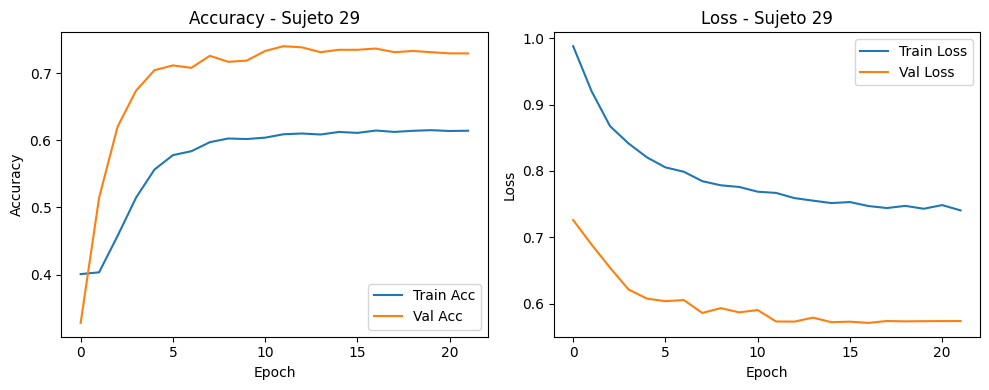

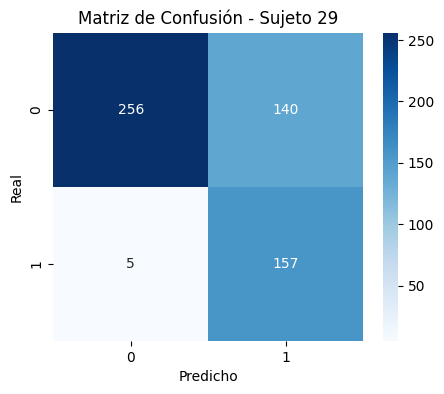

📄 Reporte de clasificación - Sujeto 29
              precision    recall  f1-score   support

           0     0.9808    0.6465    0.7793       396
           1     0.5286    0.9691    0.6841       162

    accuracy                         0.7401       558
   macro avg     0.7547    0.8078    0.7317       558
weighted avg     0.8496    0.7401    0.7517       558


🧪 Validando grupo 30 de 37
🔧 Sujeto 30: Ajuste AGRESIVO class_weight (test_ratio: 2.29)
Clases en test (sujeto 30): {0: 396, 1: 173}
Epoch 1/50
413/413 [==============================] - 4s 6ms/step - loss: 1.0970 - accuracy: 0.5602 - val_loss: 0.6836 - val_accuracy: 0.5800

Epoch 00001: val_accuracy improved from -inf to 0.57996, saving model to modelos_m\mejor_modelo_30.h5
Epoch 2/50
413/413 [==============================] - 2s 4ms/step - loss: 1.0327 - accuracy: 0.5324 - val_loss: 0.6791 - val_accuracy: 0.5782

Epoch 00002: val_accuracy did not improve from 0.57996
Epoch 3/50
413/413 [==============================] - 2s 

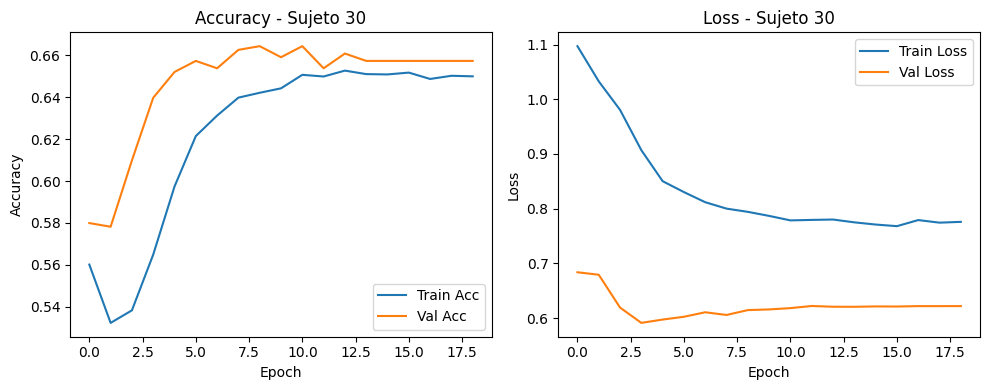

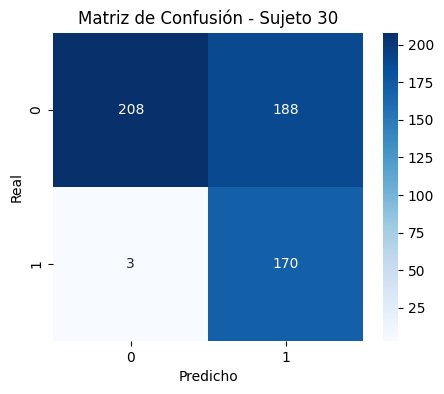

📄 Reporte de clasificación - Sujeto 30
              precision    recall  f1-score   support

           0     0.9858    0.5253    0.6853       396
           1     0.4749    0.9827    0.6403       173

    accuracy                         0.6643       569
   macro avg     0.7303    0.7540    0.6628       569
weighted avg     0.8304    0.6643    0.6716       569


🧪 Validando grupo 31 de 37
Clases en test (sujeto 31): {0: 395, 1: 155}
Epoch 1/50
826/826 [==============================] - 6s 5ms/step - loss: 0.6893 - accuracy: 0.5770 - val_loss: 0.6564 - val_accuracy: 0.6691

Epoch 00001: val_accuracy improved from -inf to 0.66909, saving model to modelos_m\mejor_modelo_31.h5
Epoch 2/50
826/826 [==============================] - 3s 4ms/step - loss: 0.6524 - accuracy: 0.6247 - val_loss: 0.5403 - val_accuracy: 0.7345

Epoch 00002: val_accuracy improved from 0.66909 to 0.73455, saving model to modelos_m\mejor_modelo_31.h5
Epoch 3/50
826/826 [==============================] - 3s 4ms/step - 

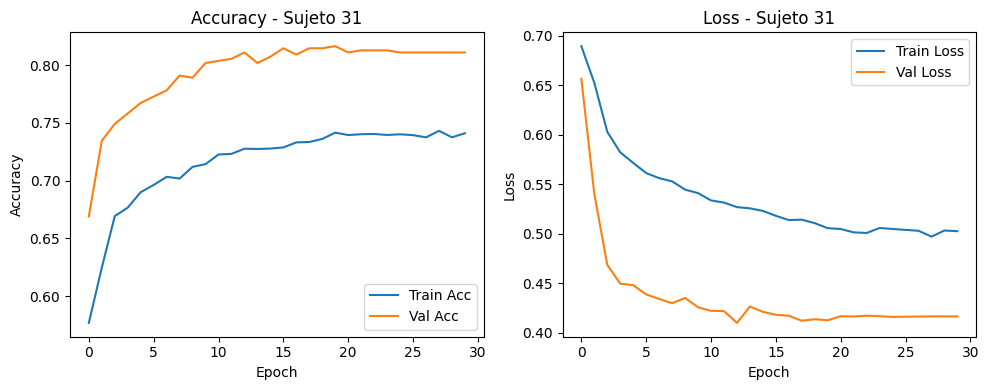

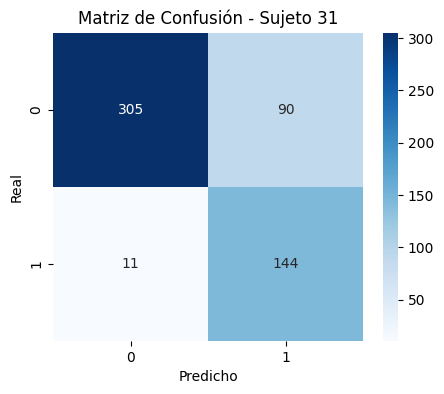

📄 Reporte de clasificación - Sujeto 31
              precision    recall  f1-score   support

           0     0.9652    0.7722    0.8579       395
           1     0.6154    0.9290    0.7404       155

    accuracy                         0.8164       550
   macro avg     0.7903    0.8506    0.7992       550
weighted avg     0.8666    0.8164    0.8248       550


🧪 Validando grupo 32 de 37
Clases en test (sujeto 32): {0: 395, 1: 160}
Epoch 1/50
826/826 [==============================] - 6s 5ms/step - loss: 0.6972 - accuracy: 0.5056 - val_loss: 0.6487 - val_accuracy: 0.7658

Epoch 00001: val_accuracy improved from -inf to 0.76577, saving model to modelos_m\mejor_modelo_32.h5
Epoch 2/50
826/826 [==============================] - 3s 4ms/step - loss: 0.6556 - accuracy: 0.5699 - val_loss: 0.5116 - val_accuracy: 0.8523

Epoch 00002: val_accuracy improved from 0.76577 to 0.85225, saving model to modelos_m\mejor_modelo_32.h5
Epoch 3/50
826/826 [==============================] - 3s 4ms/step - 

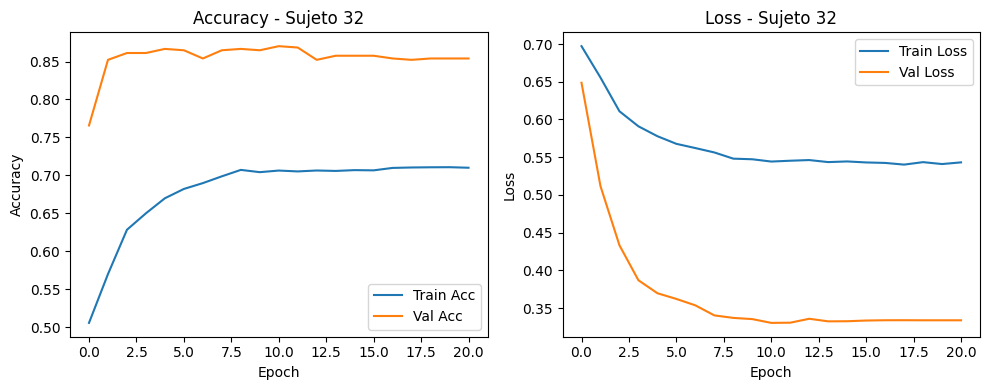

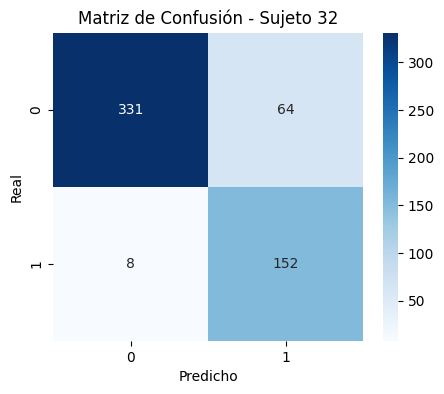

📄 Reporte de clasificación - Sujeto 32
              precision    recall  f1-score   support

           0     0.9764    0.8380    0.9019       395
           1     0.7037    0.9500    0.8085       160

    accuracy                         0.8703       555
   macro avg     0.8401    0.8940    0.8552       555
weighted avg     0.8978    0.8703    0.8750       555


🧪 Validando grupo 33 de 37
Clases en test (sujeto 33): {0: 398, 1: 167}
Epoch 1/50
826/826 [==============================] - 5s 5ms/step - loss: 0.6918 - accuracy: 0.5135 - val_loss: 0.5979 - val_accuracy: 0.7416

Epoch 00001: val_accuracy improved from -inf to 0.74159, saving model to modelos_m\mejor_modelo_33.h5
Epoch 2/50
826/826 [==============================] - 3s 4ms/step - loss: 0.6457 - accuracy: 0.6119 - val_loss: 0.5109 - val_accuracy: 0.7752

Epoch 00002: val_accuracy improved from 0.74159 to 0.77522, saving model to modelos_m\mejor_modelo_33.h5
Epoch 3/50
826/826 [==============================] - 3s 4ms/step - 

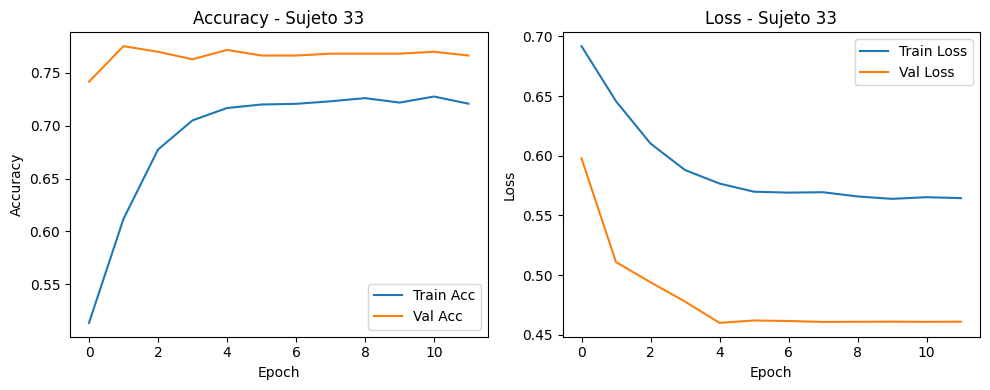

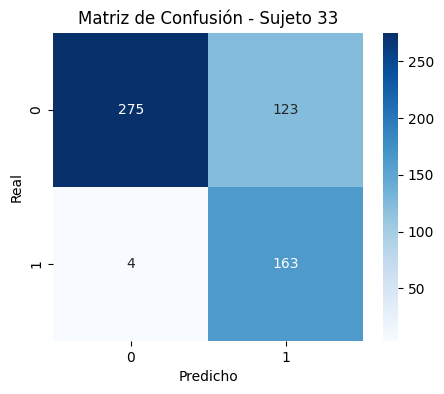

📄 Reporte de clasificación - Sujeto 33
              precision    recall  f1-score   support

           0     0.9857    0.6910    0.8124       398
           1     0.5699    0.9760    0.7196       167

    accuracy                         0.7752       565
   macro avg     0.7778    0.8335    0.7660       565
weighted avg     0.8628    0.7752    0.7850       565


🧪 Validando grupo 34 de 37
Clases en test (sujeto 34): {0: 396, 1: 161}
Epoch 1/50
826/826 [==============================] - 6s 5ms/step - loss: 0.6955 - accuracy: 0.5487 - val_loss: 0.6651 - val_accuracy: 0.4093

Epoch 00001: val_accuracy improved from -inf to 0.40934, saving model to modelos_m\mejor_modelo_34.h5
Epoch 2/50
826/826 [==============================] - 4s 4ms/step - loss: 0.6454 - accuracy: 0.6106 - val_loss: 0.6287 - val_accuracy: 0.5153

Epoch 00002: val_accuracy improved from 0.40934 to 0.51526, saving model to modelos_m\mejor_modelo_34.h5
Epoch 3/50
826/826 [==============================] - 3s 4ms/step - 

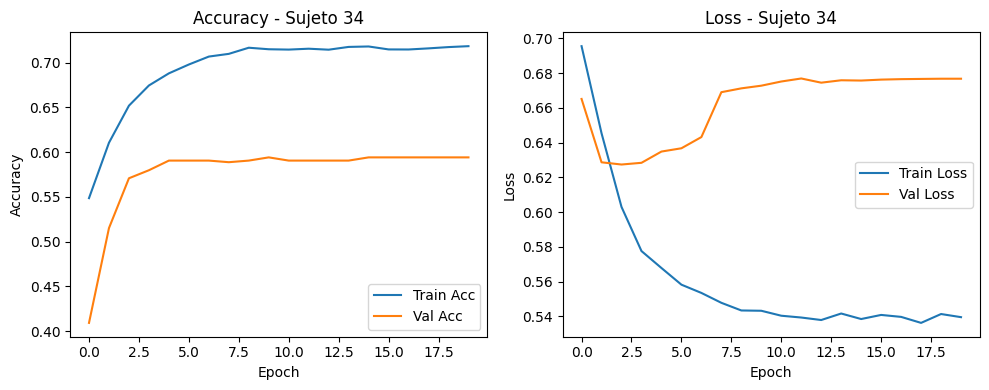

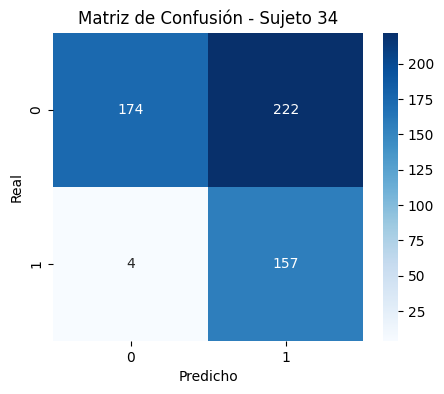

📄 Reporte de clasificación - Sujeto 34
              precision    recall  f1-score   support

           0     0.9775    0.4394    0.6063       396
           1     0.4142    0.9752    0.5815       161

    accuracy                         0.5943       557
   macro avg     0.6959    0.7073    0.5939       557
weighted avg     0.8147    0.5943    0.5991       557


🧪 Validando grupo 35 de 37
Clases en test (sujeto 35): {0: 395, 1: 164}
Epoch 1/50
826/826 [==============================] - 6s 5ms/step - loss: 0.7051 - accuracy: 0.5232 - val_loss: 0.6795 - val_accuracy: 0.6208

Epoch 00001: val_accuracy improved from -inf to 0.62075, saving model to modelos_m\mejor_modelo_35.h5
Epoch 2/50
826/826 [==============================] - 3s 4ms/step - loss: 0.6559 - accuracy: 0.6184 - val_loss: 0.6099 - val_accuracy: 0.7048

Epoch 00002: val_accuracy improved from 0.62075 to 0.70483, saving model to modelos_m\mejor_modelo_35.h5
Epoch 3/50
826/826 [==============================] - 3s 4ms/step - 

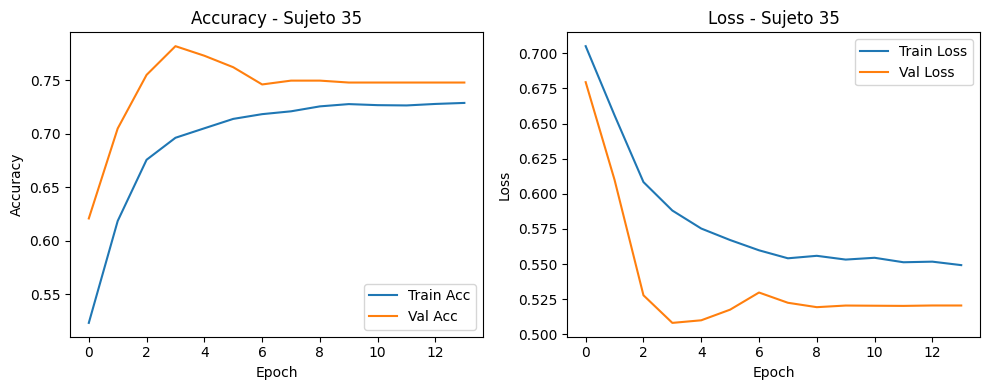

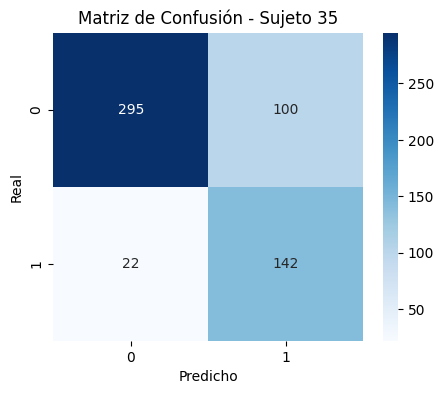

📄 Reporte de clasificación - Sujeto 35
              precision    recall  f1-score   support

           0     0.9306    0.7468    0.8287       395
           1     0.5868    0.8659    0.6995       164

    accuracy                         0.7818       559
   macro avg     0.7587    0.8063    0.7641       559
weighted avg     0.8297    0.7818    0.7908       559


🧪 Validando grupo 36 de 37
Clases en test (sujeto 36): {0: 395, 1: 160}
Epoch 1/50
826/826 [==============================] - 6s 5ms/step - loss: 0.6730 - accuracy: 0.5667 - val_loss: 0.6042 - val_accuracy: 0.6793

Epoch 00001: val_accuracy improved from -inf to 0.67928, saving model to modelos_m\mejor_modelo_36.h5
Epoch 2/50
826/826 [==============================] - 3s 4ms/step - loss: 0.6160 - accuracy: 0.6534 - val_loss: 0.5747 - val_accuracy: 0.6865

Epoch 00002: val_accuracy improved from 0.67928 to 0.68649, saving model to modelos_m\mejor_modelo_36.h5
Epoch 3/50
826/826 [==============================] - 3s 4ms/step - 

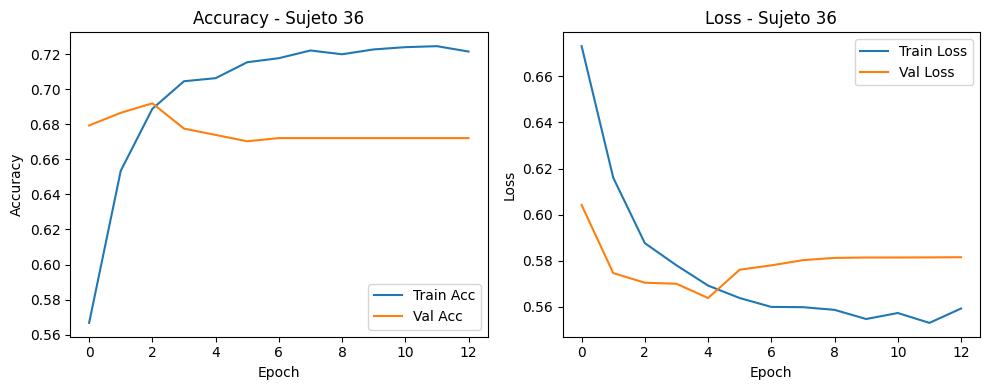

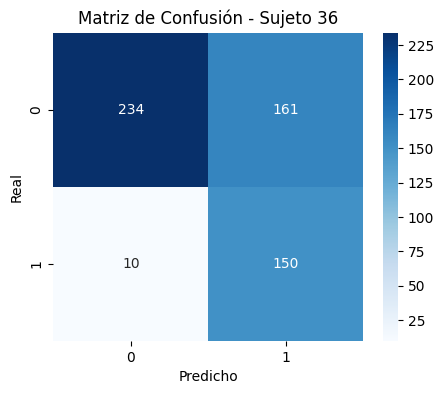

📄 Reporte de clasificación - Sujeto 36
              precision    recall  f1-score   support

           0     0.9590    0.5924    0.7324       395
           1     0.4823    0.9375    0.6369       160

    accuracy                         0.6919       555
   macro avg     0.7207    0.7650    0.6847       555
weighted avg     0.8216    0.6919    0.7049       555


🧪 Validando grupo 37 de 37
Clases en test (sujeto 37): {0: 636, 1: 492}
Epoch 1/50
808/808 [==============================] - 6s 5ms/step - loss: 0.6940 - accuracy: 0.5737 - val_loss: 0.6417 - val_accuracy: 0.7402

Epoch 00001: val_accuracy improved from -inf to 0.74025, saving model to modelos_m\mejor_modelo_37.h5
Epoch 2/50
808/808 [==============================] - 3s 4ms/step - loss: 0.6526 - accuracy: 0.6402 - val_loss: 0.5502 - val_accuracy: 0.7642

Epoch 00002: val_accuracy improved from 0.74025 to 0.76418, saving model to modelos_m\mejor_modelo_37.h5
Epoch 3/50
808/808 [==============================] - 3s 4ms/step - 

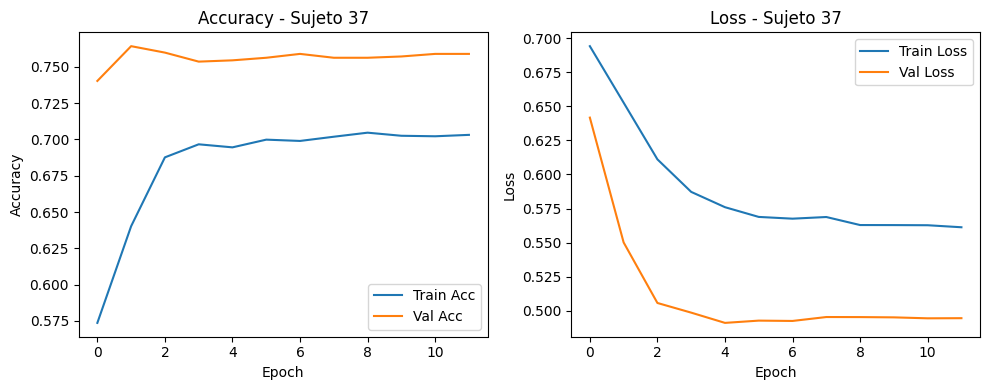

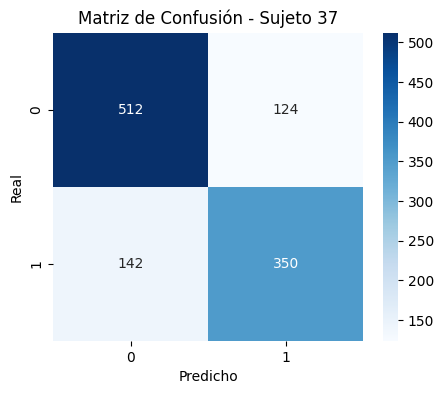

📄 Reporte de clasificación - Sujeto 37
              precision    recall  f1-score   support

           0     0.7829    0.8050    0.7938       636
           1     0.7384    0.7114    0.7246       492

    accuracy                         0.7642      1128
   macro avg     0.7606    0.7582    0.7592      1128
weighted avg     0.7635    0.7642    0.7636      1128


📊 Resultados Finales:
Promedio Accuracy: 0.7563 ± 0.1039
Promedio F1 Score: 0.7172 ± 0.0829

🔍 Análisis Train vs Val:
Diferencia promedio (Val - Train): +0.0550 ± 0.0894
Folds donde Val > Train: 30/37


In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Bidirectional, Input

accuracies = []
f1_scores = []
train_val_diffs = []  # 🆕 Para analizar diferencias

logo = LeaveOneGroupOut()
split_num = 1

for train_idx, test_idx in logo.split(X_seq, y_seq, groups=subj_seq):
    print(f"\n🧪 Validando grupo {split_num} de {len(np.unique(subjects))}")
    X_train, X_test = X_seq[train_idx], X_seq[test_idx]
    y_train, y_test = y_seq[train_idx], y_seq[test_idx]

    X_train = tf.cast(X_train, tf.float32)
    X_test = tf.cast(X_test, tf.float32)
    y_train = tf.cast(y_train, tf.int32)
    y_test = tf.cast(y_test, tf.int32)

    # ⚠️ CALLBACKS CORREGIDOS - Clave del éxito
    checkpoint = ModelCheckpoint(f"modelos_m/mejor_modelo_{split_num}.h5", 
                                monitor="val_accuracy", 
                                save_best_only=True, 
                                verbose=1)

    early_stop = EarlyStopping(monitor="val_accuracy",  # ← Cambio CRÍTICO: monitor val_accuracy
                            patience=10,  # ← CLAVE: Parar en cuanto empiece a bajar
                            restore_best_weights=True,
                            mode='max',  # ← Modo max para accuracy
                            min_delta=0.001,
                            verbose=1)

    reduce_lr = ReduceLROnPlateau(monitor="val_accuracy",  # ← Monitor accuracy, no loss
                                factor=0.2,  # ← MÁS agresivo: 5x reducción
                                patience=3,   # ← CRÍTICO: Actuar en epoch 4-5
                                min_lr=1e-8,
                                verbose=1,
                                mode='max',
                                min_delta=0.002)
    
    # 🆕 ÚNICA MEJORA NECESARIA: Ajuste dinámico de class_weights
    class_weight_dict = calculate_optimal_class_weight(y_train.numpy(), y_test.numpy(), split_num)

        # 🆕 BATCH SIZE también dinámico basado en distribución
    train_counts = np.bincount(y_train.numpy())
    test_counts = np.bincount(y_test.numpy())
    total_samples = len(y_train)
    
    if 16 <= split_num <= 30:  # Sujetos con mucha data
        batch_size = 64  # Batch más grande para estabilidad
    elif total_samples < 1000:  # Sujetos con poca data
        batch_size = 16  # Batch más pequeño para mejor gradientes
    else:
        batch_size = 32  # Default

    unique, counts = np.unique(y_test, return_counts=True)
    print(f"Clases en test (sujeto {split_num}): {dict(zip(unique, counts))}")

    # 🔄 Modelo OPTIMIZADO - Versión mejorada
    model = Sequential([
        # Arquitectura más estable
        LSTM(40, dropout=0.5, return_sequences=True, input_shape=(10, 52)),  # ← Tamaño intermedio
        Dropout(0.5),
        
        LSTM(20, dropout=0.5),  # ← Más estable
        Dropout(0.5),
        
        # Clasificador conservativo
        Dense(8, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # ← LR aún más bajo
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    with tf.device('/GPU:0'):
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=batch_size,
            validation_data=(X_test, y_test),
            callbacks=[checkpoint, reduce_lr, early_stop],
            class_weight=class_weight_dict,
            verbose=1
        )

    # Evaluar
    mejor_modelo = load_model(f"modelos_m/mejor_modelo_{split_num}.h5")
    loss, acc = mejor_modelo.evaluate(X_test, y_test, verbose=0)
    y_pred_prob = mejor_modelo.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    f1 = f1_score(y_test, y_pred)
    accuracies.append(acc)
    f1_scores.append(f1)

    # 🆕 Encontrar en qué epoch se guardó el mejor modelo
    best_epoch = np.argmax(history.history['val_accuracy']) + 1
    best_val_acc = max(history.history['val_accuracy'])
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_acc = history.history['accuracy'][-1]
    diff = final_val_acc - final_train_acc
    train_val_diffs.append(diff)
    
    print(f"✅ Accuracy: {acc:.4f} - F1: {f1:.4f}")
    print(f"🎯 Mejor modelo guardado en epoch {best_epoch} (Val Acc: {best_val_acc:.4f})")
    print(f"📉 Val Acc final: {final_val_acc:.4f} (diferencia: {final_val_acc - best_val_acc:+.4f})")
    print(f"📊 Train Acc: {final_train_acc:.4f} | Val Acc: {final_val_acc:.4f} | Diff: {diff:+.4f}")

    # ----------------------
    # 🔹 CURVAS DE ENTRENAMIENTO
    # ----------------------
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy - Sujeto {split_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss - Sujeto {split_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    # plt.savefig(f'curvas_entrenamiento_sujeto_{split_num}.png')  # Guardar imagen (opcional)

    # ----------------------
    # 🔹 MATRIZ DE CONFUSIÓN Y REPORTE
    # ----------------------
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - Sujeto {split_num}')
    plt.show()
    # plt.savefig(f'matriz_confusion_sujeto_{split_num}.png')  # Guardar imagen (opcional)

    print(f'📄 Reporte de clasificación - Sujeto {split_num}')
    print(classification_report(y_test, y_pred, digits=4))

    split_num += 1

# ----------------------
# 📊 RESULTADOS FINALES
# ----------------------
print("\n📊 Resultados Finales:")
print(f"Promedio Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Promedio F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

# 🆕 Análisis de diferencias train/val
print(f"\n🔍 Análisis Train vs Val:")
print(f"Diferencia promedio (Val - Train): {np.mean(train_val_diffs):+.4f} ± {np.std(train_val_diffs):.4f}")
print(f"Folds donde Val > Train: {sum(1 for d in train_val_diffs if d > 0)}/{len(train_val_diffs)}")

✅ Evaluando modelo 1
✅ Evaluando modelo 2
✅ Evaluando modelo 2
✅ Evaluando modelo 3
✅ Evaluando modelo 3
✅ Evaluando modelo 4
✅ Evaluando modelo 4
✅ Evaluando modelo 5
✅ Evaluando modelo 5
✅ Evaluando modelo 6
✅ Evaluando modelo 6
✅ Evaluando modelo 7
✅ Evaluando modelo 7
✅ Evaluando modelo 8
✅ Evaluando modelo 8
✅ Evaluando modelo 9
✅ Evaluando modelo 9
✅ Evaluando modelo 10
✅ Evaluando modelo 10
✅ Evaluando modelo 11
✅ Evaluando modelo 11
✅ Evaluando modelo 12
✅ Evaluando modelo 12
✅ Evaluando modelo 13
✅ Evaluando modelo 13
✅ Evaluando modelo 14
✅ Evaluando modelo 14
✅ Evaluando modelo 15
✅ Evaluando modelo 15
✅ Evaluando modelo 16
✅ Evaluando modelo 16
✅ Evaluando modelo 17
✅ Evaluando modelo 17
✅ Evaluando modelo 18
✅ Evaluando modelo 18
✅ Evaluando modelo 19
✅ Evaluando modelo 19
✅ Evaluando modelo 20
✅ Evaluando modelo 20
✅ Evaluando modelo 21
✅ Evaluando modelo 21
✅ Evaluando modelo 22
✅ Evaluando modelo 22
✅ Evaluando modelo 23
✅ Evaluando modelo 23
✅ Evaluando modelo 24
✅ Eva

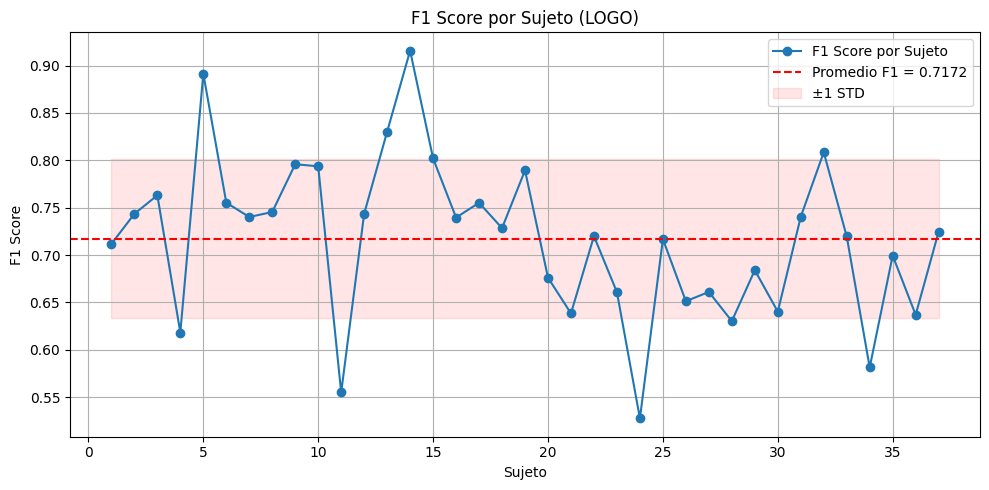


📌 Promedios generales:
Accuracy promedio: 0.7563 ± 0.1053
F1 Score promedio: 0.7172 ± 0.0841


In [16]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt

# Carpeta donde están tus modelos
MODEL_FOLDER = "modelos_m"
model_files = sorted([f for f in os.listdir(MODEL_FOLDER) if f.endswith(".h5")])

# Para almacenar resultados
results = []

logo = LeaveOneGroupOut()

split_num = 1
for train_idx, test_idx in logo.split(X_seq, y_seq, groups=subj_seq):
    model_path = os.path.join(MODEL_FOLDER, f"mejor_modelo_{split_num}.h5")
    if not os.path.exists(model_path):
        print(f"❌ Modelo no encontrado: {model_path}")
        split_num += 1
        continue

    print(f"✅ Evaluando modelo {split_num}")
    
    X_test = tf.cast(X_seq[test_idx], tf.float32)
    y_test = y_seq[test_idx]

    model = load_model(model_path)
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    unique, counts = np.unique(y_test, return_counts=True)
    class_dist = {f"class_{int(cls)}": int(count) for cls, count in zip(unique, counts)}

    results.append({
        "Sujeto": split_num,
        "Accuracy": acc,
        "F1 Score": f1,
        "Modelo": f"mejor_modelo_{split_num}.h5",
        **class_dist
    })

    split_num += 1

# Convertir a DataFrame
df_resultados = pd.DataFrame(results)

# -----------------------
# 🧾 Tabla resumida
# -----------------------
pd.set_option('display.float_format', lambda x: '%.4f' % x)
print("\n📊 Resultados por sujeto:")
print(df_resultados)

# -----------------------
# 📈 Gráfico resumen
# -----------------------
plt.figure(figsize=(10, 5))
plt.plot(df_resultados["Sujeto"], df_resultados["F1 Score"], marker='o', label="F1 Score por Sujeto")
plt.axhline(df_resultados["F1 Score"].mean(), color='r', linestyle='--', label=f"Promedio F1 = {df_resultados['F1 Score'].mean():.4f}")
plt.fill_between(df_resultados["Sujeto"],
                 df_resultados["F1 Score"].mean() - df_resultados["F1 Score"].std(),
                 df_resultados["F1 Score"].mean() + df_resultados["F1 Score"].std(),
                 color='r', alpha=0.1, label="±1 STD")

plt.title("F1 Score por Sujeto (LOGO)")
plt.xlabel("Sujeto")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------
# 🔢 Promedios generales
# -----------------------
print("\n📌 Promedios generales:")
print(f"Accuracy promedio: {df_resultados['Accuracy'].mean():.4f} ± {df_resultados['Accuracy'].std():.4f}")
print(f"F1 Score promedio: {df_resultados['F1 Score'].mean():.4f} ± {df_resultados['F1 Score'].std():.4f}")


In [17]:
# 📈 Análisis estadístico detallado
print("\n" + "="*60)
print("📈 ANÁLISIS ESTADÍSTICO DETALLADO")
print("="*60)

# Estadísticas por métrica
accuracy_stats = df_resultados['Accuracy'].describe()
f1_stats = df_resultados['F1 Score'].describe()

print(f"\n🎯 Estadísticas de Accuracy:")
print(f"   • Mínimo: {accuracy_stats['min']:.4f}")
print(f"   • Q1 (25%): {accuracy_stats['25%']:.4f}")
print(f"   • Mediana: {accuracy_stats['50%']:.4f}")
print(f"   • Q3 (75%): {accuracy_stats['75%']:.4f}")
print(f"   • Máximo: {accuracy_stats['max']:.4f}")
print(f"   • Desviación estándar: {accuracy_stats['std']:.4f}")

print(f"\n🎯 Estadísticas de F1 Score:")
print(f"   • Mínimo: {f1_stats['min']:.4f}")
print(f"   • Q1 (25%): {f1_stats['25%']:.4f}")
print(f"   • Mediana: {f1_stats['50%']:.4f}")
print(f"   • Q3 (75%): {f1_stats['75%']:.4f}")
print(f"   • Máximo: {f1_stats['max']:.4f}")
print(f"   • Desviación estándar: {f1_stats['std']:.4f}")

# Identificar mejores y peores sujetos
best_acc_idx = df_resultados['Accuracy'].idxmax()
worst_acc_idx = df_resultados['Accuracy'].idxmin()
best_f1_idx = df_resultados['F1 Score'].idxmax()
worst_f1_idx = df_resultados['F1 Score'].idxmin()

print(f"\n🏆 Mejores y peores resultados:")
print(f"   • Mejor Accuracy: Sujeto {df_resultados.loc[best_acc_idx, 'Sujeto']} ({df_resultados.loc[best_acc_idx, 'Accuracy']:.4f})")
print(f"   • Peor Accuracy: Sujeto {df_resultados.loc[worst_acc_idx, 'Sujeto']} ({df_resultados.loc[worst_acc_idx, 'Accuracy']:.4f})")
print(f"   • Mejor F1: Sujeto {df_resultados.loc[best_f1_idx, 'Sujeto']} ({df_resultados.loc[best_f1_idx, 'F1 Score']:.4f})")
print(f"   • Peor F1: Sujeto {df_resultados.loc[worst_f1_idx, 'Sujeto']} ({df_resultados.loc[worst_f1_idx, 'F1 Score']:.4f})")

# Confiabilidad del modelo
variability_acc = df_resultados['Accuracy'].std() / df_resultados['Accuracy'].mean()
variability_f1 = df_resultados['F1 Score'].std() / df_resultados['F1 Score'].mean()

print(f"\n📊 Consistencia del modelo (Coeficiente de Variación):")
print(f"   • Accuracy CV: {variability_acc:.4f} ({'Muy consistente' if variability_acc < 0.1 else 'Moderadamente consistente' if variability_acc < 0.2 else 'Variable'})")
print(f"   • F1 Score CV: {variability_f1:.4f} ({'Muy consistente' if variability_f1 < 0.1 else 'Moderadamente consistente' if variability_f1 < 0.2 else 'Variable'})")

# Umbral de rendimiento
good_performance_threshold = 0.8
excellent_performance_threshold = 0.9

good_acc_count = (df_resultados['Accuracy'] >= good_performance_threshold).sum()
excellent_acc_count = (df_resultados['Accuracy'] >= excellent_performance_threshold).sum()
good_f1_count = (df_resultados['F1 Score'] >= good_performance_threshold).sum()
excellent_f1_count = (df_resultados['F1 Score'] >= excellent_performance_threshold).sum()

total_subjects = len(df_resultados)

print(f"\n🎯 Distribución de rendimiento:")
print(f"   • Sujetos con Accuracy ≥ 80%: {good_acc_count}/{total_subjects} ({good_acc_count/total_subjects*100:.1f}%)")
print(f"   • Sujetos con Accuracy ≥ 90%: {excellent_acc_count}/{total_subjects} ({excellent_acc_count/total_subjects*100:.1f}%)")
print(f"   • Sujetos con F1 Score ≥ 80%: {good_f1_count}/{total_subjects} ({good_f1_count/total_subjects*100:.1f}%)")
print(f"   • Sujetos con F1 Score ≥ 90%: {excellent_f1_count}/{total_subjects} ({excellent_f1_count/total_subjects*100:.1f}%)")


📈 ANÁLISIS ESTADÍSTICO DETALLADO

🎯 Estadísticas de Accuracy:
   • Mínimo: 0.5013
   • Q1 (25%): 0.7024
   • Mediana: 0.7668
   • Q3 (75%): 0.8288
   • Máximo: 0.9502
   • Desviación estándar: 0.1053

🎯 Estadísticas de F1 Score:
   • Mínimo: 0.5277
   • Q1 (25%): 0.6609
   • Mediana: 0.7246
   • Q3 (75%): 0.7553
   • Máximo: 0.9157
   • Desviación estándar: 0.0841

🏆 Mejores y peores resultados:
   • Mejor Accuracy: Sujeto 14 (0.9502)
   • Peor Accuracy: Sujeto 24 (0.5013)
   • Mejor F1: Sujeto 14 (0.9157)
   • Peor F1: Sujeto 24 (0.5277)

📊 Consistencia del modelo (Coeficiente de Variación):
   • Accuracy CV: 0.1393 (Moderadamente consistente)
   • F1 Score CV: 0.1172 (Moderadamente consistente)

🎯 Distribución de rendimiento:
   • Sujetos con Accuracy ≥ 80%: 14/37 (37.8%)
   • Sujetos con Accuracy ≥ 90%: 2/37 (5.4%)
   • Sujetos con F1 Score ≥ 80%: 5/37 (13.5%)
   • Sujetos con F1 Score ≥ 90%: 1/37 (2.7%)
